In [1]:
import os
import torch
import torchaudio
torchaudio.set_audio_backend("sox_io")
import pandas as pd
import numpy as np
import torch.nn.functional as F
import random
import scipy
import math
from scipy import signal
import librosa.display
import torch.nn as nn
from torch.utils.data import DataLoader

GAMMA = 3.33
DATA = 'ravdess_MFCC'
LAYERS = 1
ROOT = './Dataset/{}'.format(DATA)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
MODEL_PATH = './model/{}_DANN_{}L-CNN-GRU_DAP{}_CV'.format(DATA,LAYERS,GAMMA)
NPARR_PATH = './array/{}_DANN_{}L-CNN-GRU_DAP{}_CV accuracies.npz'.format(DATA,LAYERS,GAMMA)

/home/bryan/miniconda3/envs/FYP/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def set_seed(sd):
    np.random.seed(sd)
    random.seed(sd)
    random.Random(sd)
    torch.manual_seed(sd)
    torch.cuda.manual_seed(sd)
    torch.cuda.manual_seed_all(sd)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("Seed set to:{}".format(sd))
# also set worker_init_fn=np.random.seed(0),num_workers=0 in dataloader   

set_seed(42)

Seed set to:42


## 1. CV Dataset for Ravdess

In [3]:
class RavdessDataset2(object):
    """
        Create a Dataset for RAVDESS. Each item is a tuple of the form:
        (feature, emotion, speaker)
    """ 
    
    # Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
    _emotions = { '01': 0, '02': 1, '03': 2, '04': 3, '05': 4, '06': 5, '07': 6, '08': 7 }
 
    _speaker = {'0'+ str(i+1): i for i in range(24) if i< 9}
    _speaker.update({str(i+1): i for i in range(24) if i>= 9})

    
    def __init__(self, root, cv_index, split):
        """
        Args:
            root (string): Directory containing the wav files
            split(string): Either train, validate or test set
        """
        self.root = root
        self.data = []
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])
        self.allActors = ['0'+ str(i+1) for i in range(24)if i<9] + [str(i+1) for i in range(24)if i>=9]
        
        self.cv = { 0:  (['01','02'],['03','04']),
                    1:  (['03','04'],['05','06']),
                    2:  (['05','06'],['07','08']),
                    3:  (['07','08'],['09','10']),
                    4:  (['09','10'],['11','12']),
                    5:  (['11','12'],['13','14']),
                    6:  (['13','14'],['15','16']),
                    7:  (['15','16'],['17','18']),
                    8:  (['17','18'],['19','20']),
                    9:  (['19','20'],['21','22']),
                    10: (['21','22'],['23','24']),
                    11: (['23','24'],['01','02'])
                  }

        # Iterate through all audio files
        for root, dirs, files in os.walk(root):
            for file in files: 
                
                if split == 'train':
                    if file[-5:-3] in [x for x in self.allActors if x not in (self.cv[cv_index][0]+ self.cv[cv_index][1])]:
                        self.data.append([file[-5:-3],file[6:8],file])
                        
                elif split == 'validate':
                    if file[-5:-3] in self.cv[cv_index][0]:
                        self.data.append([file[-5:-3],file[6:8],file])
                        
                elif split == 'test':
                    if file[-5:-3] in self.cv[cv_index][1]:
                        self.data.append([file[-5:-3],file[6:8],file])
                else:
                    print("Error: Split can only be train, validate or test!")

        # Convert data to pandas dataframe
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])

        # Map emotion labels to numeric values
        self.df['Emotion'] = self.df['Emotion'].map(self._emotions).astype(np.long)
        self.df['Speaker'] = self.df['Speaker'].map(self._speaker).astype(np.long)

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):

        file_name = os.path.join(self.root, self.df.loc[idx, 'File'])
        feature = torch.load(file_name )
        emotion = self.df.loc[idx, 'Emotion']
        speaker = self.df.loc[idx, 'Speaker']
        
        # return a tuple instead of a dictionary
        sample = (feature,emotion,speaker)

        return sample

In [4]:
# # Initialize RavdessDataset
# ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = 4,split= 'train')
# ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = 4,split= 'test')
# ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = 4, split= 'validate')

# # To view dataframe, uncomment below: 
# ravdess_dataset_train.df

In [5]:
# from torch.utils.data import DataLoader
# TRAIN_BATCH_SIZE = 16
# VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
# TEST_BATCH_SIZE = len(ravdess_dataset_test)
# ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)
# ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)
# ravdess_test_loader = DataLoader(dataset=ravdess_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)

In [6]:
# next(iter(ravdess_train_loader))

## 2. Network Architectures and Helper Functions

### 2.1 Network Architectures

In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        # For same padding, P = ((S-1)*W-S+F)/2, with F = filter size, S = stride. If stride = 1, P = (F-1)/2
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(2, 2),padding=1,bias=False),  
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
                     
        )
        
        self.GRU = nn.GRU(input_size= 640, hidden_size = 256 ,batch_first = True, bidirectional = True) #128
        self.global_average_pooling = nn.AdaptiveAvgPool2d((8,8))
        self.FC = nn.Linear(in_features = 8 * 8, out_features = 512) 
        
        
    def forward(self,x):
        x = self.conv_layers(x)
        # print("1-LFLB shape: {}".format(x.shape))                     # batch_size, c_out, freq, time since we are using spectogram
        x = x.view(x.size(0),-1,x.size(3)) 
        # print("Batch size, features, seq shape: {}".format(x.shape))  # batch_size, features= c_out* freq , seq_len= time
        x = x.permute(0,2,1)
        # print("Batch size, seq, features shape: {}".format(x.shape))  # batch_size, seq, features
        output, hn = self.GRU(x)
        # print("GRU output shape: {}".format(output.shape))                # batch_size, seq, hidden size * 2 
        x = self.global_average_pooling(output)
        # print("Shape after global average pooling:{}".format(x.shape))
        x = torch.flatten(x,start_dim=1)
        # print("Shape after flattening:{}".format(x.shape))
        x = self.FC(x)
        # print("FC shape: {}".format(x.shape))

        return x


In [8]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 8),

        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


In [9]:
class SpeakerClassifier(nn.Module):
    def __init__(self):
        super(SpeakerClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 24),
        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


### 2.2 Helper Functions

In [10]:
import numpy as np

def domain_adaptation_parameter(p):
    lambda_p = 2. / (1. + np.exp(-GAMMA*p)) - 1
    return lambda_p

In [11]:
def save_parameters(PATH):
    torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'emotion_classifier_state_dict': emotion_classifier.state_dict(),
                'speaker_classifier_state_dict': speaker_classifier.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'emotion_optimizer_state_dict': emotion_optimizer.state_dict(),
                'speaker_optimizer_state_dict': speaker_optimizer.state_dict(),
                }, PATH)
    print("Models' parameters and optimisers' parameters saved.")

In [12]:
def save_accuracies_and_losses(PATH):
    np.savez(PATH, 
         emoClassLoss = fold_emotion_class_losses,
         emoTrain_acc = fold_emotion_training_accuracies, 
         emoValidate_acc = fold_emotion_validating_accuracies,
         spkClassLoss = fold_speaker_class_losses,
         spkTrain_acc = fold_speaker_training_accuracies,
         spkValidate_acc = fold_speaker_validating_accuracies,
        
    )

## 4. Model Training

In [13]:
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
import pylab as plt

# Read this to understand how GRL works: 
# https://christineai.blog/category/domain-adaptation/

FOLDS = 12
EPOCHS = 100

############### To comment this section out if disrupted #############
fold_emotion_class_losses = np.zeros((FOLDS,EPOCHS))
fold_emotion_training_accuracies = np.zeros((FOLDS,EPOCHS))
fold_emotion_validating_accuracies = np.zeros((FOLDS,EPOCHS))
fold_speaker_class_losses = np.zeros((FOLDS,EPOCHS))
fold_speaker_training_accuracies = np.zeros((FOLDS,EPOCHS))
fold_speaker_validating_accuracies = np.zeros((FOLDS,EPOCHS))


######### To uncomment if trying to continue disrupted training ######
# fold_emotion_class_losses, fold_emotion_training_accuracies, fold_emotion_validating_accuracies， fold_speaker_class_losses，fold_speaker_training_accuracies，fold_speaker_validating_accuracies= np.load(NPARR_PATH)

###################################################################

# 5-fold cross validation
for fold in range(0,FOLDS):

    # Selecting CPU or GPU
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # DEVICE = torch.device("cpu")

    # Selecting the type of encoder, label classifier
    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    speaker_classifier = SpeakerClassifier().to(DEVICE).train()

    # Optimizer 
    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())

    cross_entropy_loss = nn.CrossEntropyLoss().to(DEVICE)
    
    ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = fold ,split= 'train')
    ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = fold, split= 'test')
    ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = fold, split= 'validate')
    
    # DANN should be trained on labelled data from the source domain and unlabelled data from the target domain
    TRAIN_BATCH_SIZE = 32
    ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=True,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory= True)
    
    # For evaluation purposes
    VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
    ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory= True)
    
    epoch_emotion_class_losses = []
    emotion_training_accuracies = []
    emotion_validating_accuracies = []

    epoch_speaker_class_losses = []
    speaker_training_accuracies = []
    speaker_validating_accuracies = []

    STEP = 0
    for epoch in range(EPOCHS):
        print("\nCurrent Fold: {} | Epoch: {}".format(fold, epoch))

        completed_start_steps = epoch * len(ravdess_train_loader)
        total_steps = EPOCHS * len(ravdess_train_loader)

        batch_emotion_class_losses = []
        batch_speaker_class_losses = []


        for batch_idx, (feature, emotion, speaker) in enumerate(ravdess_train_loader):

            # Assigned to DEVICE. 
            features, emotion, speaker = feature.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE)
            
            # Computing the training progress
            p = (batch_idx + completed_start_steps) / total_steps
            lambda_p = domain_adaptation_parameter(p)

            # Calculate speaker and emotion classification prediction 
            conv_features = encoder(features)
            emotion_preds = emotion_classifier(conv_features)
            emotion_class_loss = cross_entropy_loss(emotion_preds, emotion)
            speaker_preds = speaker_classifier(conv_features)
            speaker_class_loss = cross_entropy_loss(speaker_preds, speaker)

            # Calculate total loss
            total_loss = emotion_class_loss - lambda_p * speaker_class_loss 

            # Clear the gradient to prevent gradient accumulation
            encoder.zero_grad(set_to_none= True)
            emotion_classifier.zero_grad(set_to_none= True)
            speaker_classifier.zero_grad(set_to_none= True)

            # Computing the gradient
            total_loss.backward()

            # Update the weight
            emotion_optimizer.step()
            speaker_optimizer.step()
            encoder_optimizer.step()

            batch_emotion_class_losses.append(emotion_class_loss.detach())
            batch_speaker_class_losses.append(speaker_class_loss.detach())


        # Enter evaluation mode at the end of each epoch
        encoder.eval()
        emotion_classifier.eval()
        speaker_classifier.eval()

        emotion_training_correct, emotion_validating_correct, speaker_training_correct, speaker_validating_correct = 0 , 0 , 0 , 0

        with torch.no_grad():

        # 1. Training Classification
          for index, (features, emotion, speaker) in enumerate(ravdess_train_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            emotion_training_correct += (emotion_preds == emotion).sum() 
            speaker_training_correct += (speaker_preds == speaker).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_training_accuracy = emotion_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
          emotion_training_accuracies.append(emotion_training_accuracy)
          speaker_training_accuracy = speaker_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
          speaker_training_accuracies.append(speaker_training_accuracy)
          print("Emotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(emotion_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))
          print("Speaker Training Correct: {}/{} \nSpeaker Training Accuracy: {:.5f}%".format(speaker_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),speaker_training_accuracy*100))

        # 2. Validating Classification
          for index, (features, emotion, speaker) in enumerate(ravdess_validate_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            emotion_validating_correct += (emotion_preds == emotion).sum() 
            speaker_validating_correct += (speaker_preds == speaker).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_validating_accuracy = emotion_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
          emotion_validating_accuracies.append(emotion_validating_accuracy)
          speaker_validating_accuracy = speaker_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
          speaker_validating_accuracies.append(speaker_validating_accuracy)
          print("\nEmotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(emotion_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))
          print("Speaker Validating Correct: {}/{} \nSpeaker Validating Accuracy: {:.5f}%".format(speaker_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),speaker_validating_accuracy*100))

          if (len(emotion_validating_accuracies)> 1 and emotion_validating_accuracy >= max(emotion_validating_accuracies[:-1])):
                save_parameters(MODEL_PATH + 'fold' + str(fold))


        encoder.train()
        emotion_classifier.train()
        speaker_classifier.train()


        epoch_emotion_class_loss = torch.mean(torch.stack(batch_emotion_class_losses), dim=0)
        epoch_emotion_class_losses.append(epoch_emotion_class_loss)
        epoch_speaker_class_loss = torch.mean(torch.stack(batch_speaker_class_losses), dim=0)
        epoch_speaker_class_losses.append(epoch_speaker_class_loss)
        
    fold_emotion_class_losses[fold] = epoch_emotion_class_losses
    fold_emotion_training_accuracies[fold] = emotion_training_accuracies
    fold_emotion_validating_accuracies[fold] = emotion_validating_accuracies
    fold_speaker_class_losses[fold] = epoch_speaker_class_losses
    fold_speaker_training_accuracies[fold] = speaker_training_accuracies
    fold_speaker_validating_accuracies[fold] = speaker_validating_accuracies
    
    save_accuracies_and_losses(NPARR_PATH)
    
    
    



Current Fold: 0 | Epoch: 0


Emotion Training Correct: 384/1184 
Emotion Training Accuracy: 32.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 0 | Epoch: 1


Emotion Training Correct: 411/1184 
Emotion Training Accuracy: 34.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 2


Emotion Training Correct: 491/1184 
Emotion Training Accuracy: 41.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 0 | Epoch: 3


Emotion Training Correct: 507/1184 
Emotion Training Accuracy: 42.82095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 4


Emotion Training Correct: 555/1184 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 5


Emotion Training Correct: 559/1184 
Emotion Training Accuracy: 47.21284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 6


Emotion Training Correct: 585/1184 
Emotion Training Accuracy: 49.40878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 7


Emotion Training Correct: 598/1184 
Emotion Training Accuracy: 50.50676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 8


Emotion Training Correct: 643/1184 
Emotion Training Accuracy: 54.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 9


Emotion Training Correct: 695/1184 
Emotion Training Accuracy: 58.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 10


Emotion Training Correct: 650/1184 
Emotion Training Accuracy: 54.89865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 11


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 12


Emotion Training Correct: 749/1184 
Emotion Training Accuracy: 63.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 13


Emotion Training Correct: 763/1184 
Emotion Training Accuracy: 64.44257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 14


Emotion Training Correct: 781/1184 
Emotion Training Accuracy: 65.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 15


Emotion Training Correct: 796/1184 
Emotion Training Accuracy: 67.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 16


Emotion Training Correct: 776/1184 
Emotion Training Accuracy: 65.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 17


Emotion Training Correct: 792/1184 
Emotion Training Accuracy: 66.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 18


Emotion Training Correct: 789/1184 
Emotion Training Accuracy: 66.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 19


Emotion Training Correct: 813/1184 
Emotion Training Accuracy: 68.66554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 20


Emotion Training Correct: 776/1184 
Emotion Training Accuracy: 65.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 21


Emotion Training Correct: 809/1184 
Emotion Training Accuracy: 68.32770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 22


Emotion Training Correct: 831/1184 
Emotion Training Accuracy: 70.18581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 23


Emotion Training Correct: 847/1184 
Emotion Training Accuracy: 71.53716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 24


Emotion Training Correct: 874/1184 
Emotion Training Accuracy: 73.81757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 25


Emotion Training Correct: 888/1184 
Emotion Training Accuracy: 75.00000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 26


Emotion Training Correct: 869/1184 
Emotion Training Accuracy: 73.39527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 27


Emotion Training Correct: 889/1184 
Emotion Training Accuracy: 75.08446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 28


Emotion Training Correct: 906/1184 
Emotion Training Accuracy: 76.52027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 29


Emotion Training Correct: 927/1184 
Emotion Training Accuracy: 78.29392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 30


Emotion Training Correct: 890/1184 
Emotion Training Accuracy: 75.16892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 31


Emotion Training Correct: 956/1184 
Emotion Training Accuracy: 80.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 32


Emotion Training Correct: 916/1184 
Emotion Training Accuracy: 77.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 33


Emotion Training Correct: 906/1184 
Emotion Training Accuracy: 76.52027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 34


Emotion Training Correct: 932/1184 
Emotion Training Accuracy: 78.71622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 35


Emotion Training Correct: 926/1184 
Emotion Training Accuracy: 78.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 36


Emotion Training Correct: 984/1184 
Emotion Training Accuracy: 83.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 37


Emotion Training Correct: 910/1184 
Emotion Training Accuracy: 76.85811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 38


Emotion Training Correct: 953/1184 
Emotion Training Accuracy: 80.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 39


Emotion Training Correct: 983/1184 
Emotion Training Accuracy: 83.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 40


Emotion Training Correct: 985/1184 
Emotion Training Accuracy: 83.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 41


Emotion Training Correct: 976/1184 
Emotion Training Accuracy: 82.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 42


Emotion Training Correct: 991/1184 
Emotion Training Accuracy: 83.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 43


Emotion Training Correct: 928/1184 
Emotion Training Accuracy: 78.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 44


Emotion Training Correct: 1022/1184 
Emotion Training Accuracy: 86.31757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 45


Emotion Training Correct: 998/1184 
Emotion Training Accuracy: 84.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 46


Emotion Training Correct: 1032/1184 
Emotion Training Accuracy: 87.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 47


Emotion Training Correct: 1039/1184 
Emotion Training Accuracy: 87.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 48


Emotion Training Correct: 1029/1184 
Emotion Training Accuracy: 86.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 49


Emotion Training Correct: 1043/1184 
Emotion Training Accuracy: 88.09122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 50


Emotion Training Correct: 1052/1184 
Emotion Training Accuracy: 88.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 51


Emotion Training Correct: 1033/1184 
Emotion Training Accuracy: 87.24662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 52


Emotion Training Correct: 1057/1184 
Emotion Training Accuracy: 89.27365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 53


Emotion Training Correct: 1046/1184 
Emotion Training Accuracy: 88.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 54


Emotion Training Correct: 1034/1184 
Emotion Training Accuracy: 87.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 55


Emotion Training Correct: 1036/1184 
Emotion Training Accuracy: 87.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 56


Emotion Training Correct: 1050/1184 
Emotion Training Accuracy: 88.68243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 57


Emotion Training Correct: 1052/1184 
Emotion Training Accuracy: 88.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 58


Emotion Training Correct: 1052/1184 
Emotion Training Accuracy: 88.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 59


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 60


Emotion Training Correct: 1035/1184 
Emotion Training Accuracy: 87.41554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 61


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 62


Emotion Training Correct: 1064/1184 
Emotion Training Accuracy: 89.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 63


Emotion Training Correct: 1048/1184 
Emotion Training Accuracy: 88.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 64


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 65


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 66


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 67


Emotion Training Correct: 1078/1184 
Emotion Training Accuracy: 91.04730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 68


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 69


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 70


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 71


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 72


Emotion Training Correct: 1066/1184 
Emotion Training Accuracy: 90.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 73


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 74


Emotion Training Correct: 1065/1184 
Emotion Training Accuracy: 89.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 75


Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 76


Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 77


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 78


Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 79


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 80


Emotion Training Correct: 1078/1184 
Emotion Training Accuracy: 91.04730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 81


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 82


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 83


Emotion Training Correct: 1049/1184 
Emotion Training Accuracy: 88.59797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 84


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 85


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 86


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 87


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 88


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 89


Emotion Training Correct: 1079/1184 
Emotion Training Accuracy: 91.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 90


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 91


Emotion Training Correct: 1094/1184 
Emotion Training Accuracy: 92.39865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 92


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 93


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 94


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 95


Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 96


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 97


Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 98


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 0 | Epoch: 99


Emotion Training Correct: 1092/1184 
Emotion Training Accuracy: 92.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Current Fold: 1 | Epoch: 0


Emotion Training Correct: 328/1184 
Emotion Training Accuracy: 27.70270%
Speaker Training Correct: 2/1184 
Speaker Training Accuracy: 0.16892%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 1 | Epoch: 1


Emotion Training Correct: 423/1184 
Emotion Training Accuracy: 35.72635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 2


Emotion Training Correct: 532/1184 
Emotion Training Accuracy: 44.93243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 3


Emotion Training Correct: 569/1184 
Emotion Training Accuracy: 48.05743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 4


Emotion Training Correct: 549/1184 
Emotion Training Accuracy: 46.36824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 5


Emotion Training Correct: 528/1184 
Emotion Training Accuracy: 44.59459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 6


Emotion Training Correct: 618/1184 
Emotion Training Accuracy: 52.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 1 | Epoch: 7


Emotion Training Correct: 628/1184 
Emotion Training Accuracy: 53.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 1 | Epoch: 8


Emotion Training Correct: 656/1184 
Emotion Training Accuracy: 55.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 9


Emotion Training Correct: 641/1184 
Emotion Training Accuracy: 54.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 1 | Epoch: 10


Emotion Training Correct: 704/1184 
Emotion Training Accuracy: 59.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 1 | Epoch: 11


Emotion Training Correct: 696/1184 
Emotion Training Accuracy: 58.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 12


Emotion Training Correct: 716/1184 
Emotion Training Accuracy: 60.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 1 | Epoch: 13


Emotion Training Correct: 724/1184 
Emotion Training Accuracy: 61.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 1 | Epoch: 14


Emotion Training Correct: 759/1184 
Emotion Training Accuracy: 64.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 1 | Epoch: 15


Emotion Training Correct: 812/1184 
Emotion Training Accuracy: 68.58108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 16


Emotion Training Correct: 817/1184 
Emotion Training Accuracy: 69.00338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 1 | Epoch: 17


Emotion Training Correct: 824/1184 
Emotion Training Accuracy: 69.59459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 1 | Epoch: 18


Emotion Training Correct: 841/1184 
Emotion Training Accuracy: 71.03041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 19


Emotion Training Correct: 817/1184 
Emotion Training Accuracy: 69.00338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 20


Emotion Training Correct: 838/1184 
Emotion Training Accuracy: 70.77703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 1 | Epoch: 21


Emotion Training Correct: 834/1184 
Emotion Training Accuracy: 70.43919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%

Current Fold: 1 | Epoch: 22


Emotion Training Correct: 839/1184 
Emotion Training Accuracy: 70.86149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 1 | Epoch: 23


Emotion Training Correct: 866/1184 
Emotion Training Accuracy: 73.14189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 1 | Epoch: 24


Emotion Training Correct: 880/1184 
Emotion Training Accuracy: 74.32432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 1 | Epoch: 25


Emotion Training Correct: 900/1184 
Emotion Training Accuracy: 76.01351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 1 | Epoch: 26


Emotion Training Correct: 908/1184 
Emotion Training Accuracy: 76.68919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 1 | Epoch: 27


Emotion Training Correct: 920/1184 
Emotion Training Accuracy: 77.70270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 1 | Epoch: 28


Emotion Training Correct: 955/1184 
Emotion Training Accuracy: 80.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 1 | Epoch: 29


Emotion Training Correct: 931/1184 
Emotion Training Accuracy: 78.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 1 | Epoch: 30


Emotion Training Correct: 945/1184 
Emotion Training Accuracy: 79.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 1 | Epoch: 31


Emotion Training Correct: 918/1184 
Emotion Training Accuracy: 77.53378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 1 | Epoch: 32


Emotion Training Correct: 979/1184 
Emotion Training Accuracy: 82.68581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 1 | Epoch: 33


Emotion Training Correct: 965/1184 
Emotion Training Accuracy: 81.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 1 | Epoch: 34


Emotion Training Correct: 972/1184 
Emotion Training Accuracy: 82.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 1 | Epoch: 35


Emotion Training Correct: 978/1184 
Emotion Training Accuracy: 82.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 1 | Epoch: 36


Emotion Training Correct: 994/1184 
Emotion Training Accuracy: 83.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 1 | Epoch: 37


Emotion Training Correct: 1008/1184 
Emotion Training Accuracy: 85.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 1 | Epoch: 38


Emotion Training Correct: 1010/1184 
Emotion Training Accuracy: 85.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 1 | Epoch: 39


Emotion Training Correct: 943/1184 
Emotion Training Accuracy: 79.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 1 | Epoch: 40


Emotion Training Correct: 1018/1184 
Emotion Training Accuracy: 85.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 41


Emotion Training Correct: 1004/1184 
Emotion Training Accuracy: 84.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 42


Emotion Training Correct: 999/1184 
Emotion Training Accuracy: 84.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 43


Emotion Training Correct: 1036/1184 
Emotion Training Accuracy: 87.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 1 | Epoch: 44


Emotion Training Correct: 1031/1184 
Emotion Training Accuracy: 87.07770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 45


Emotion Training Correct: 1040/1184 
Emotion Training Accuracy: 87.83784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 1 | Epoch: 46


Emotion Training Correct: 1018/1184 
Emotion Training Accuracy: 85.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 1 | Epoch: 47


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 1 | Epoch: 48


Emotion Training Correct: 1017/1184 
Emotion Training Accuracy: 85.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 49


Emotion Training Correct: 1036/1184 
Emotion Training Accuracy: 87.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 50


Emotion Training Correct: 1047/1184 
Emotion Training Accuracy: 88.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 1 | Epoch: 51


Emotion Training Correct: 1039/1184 
Emotion Training Accuracy: 87.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 1 | Epoch: 52


Emotion Training Correct: 1047/1184 
Emotion Training Accuracy: 88.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 53


Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 1 | Epoch: 54


Emotion Training Correct: 1048/1184 
Emotion Training Accuracy: 88.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 1 | Epoch: 55


Emotion Training Correct: 1016/1184 
Emotion Training Accuracy: 85.81081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 1 | Epoch: 56


Emotion Training Correct: 1020/1184 
Emotion Training Accuracy: 86.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 57


Emotion Training Correct: 1036/1184 
Emotion Training Accuracy: 87.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 1 | Epoch: 58


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 1 | Epoch: 59


Emotion Training Correct: 1064/1184 
Emotion Training Accuracy: 89.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 60


Emotion Training Correct: 1065/1184 
Emotion Training Accuracy: 89.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 1 | Epoch: 61


Emotion Training Correct: 1048/1184 
Emotion Training Accuracy: 88.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 1 | Epoch: 62


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 63


Emotion Training Correct: 1064/1184 
Emotion Training Accuracy: 89.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 1 | Epoch: 64


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 1 | Epoch: 65


Emotion Training Correct: 1062/1184 
Emotion Training Accuracy: 89.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 1 | Epoch: 66


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 1 | Epoch: 67


Emotion Training Correct: 1079/1184 
Emotion Training Accuracy: 91.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 1 | Epoch: 68


Emotion Training Correct: 1070/1184 
Emotion Training Accuracy: 90.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 1 | Epoch: 69


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 1 | Epoch: 70


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 1 | Epoch: 71


Emotion Training Correct: 1070/1184 
Emotion Training Accuracy: 90.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 1 | Epoch: 72


Emotion Training Correct: 1054/1184 
Emotion Training Accuracy: 89.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 1 | Epoch: 73


Emotion Training Correct: 1057/1184 
Emotion Training Accuracy: 89.27365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 1 | Epoch: 74


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 1 | Epoch: 75


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 1 | Epoch: 76


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 1 | Epoch: 77


Emotion Training Correct: 1066/1184 
Emotion Training Accuracy: 90.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 1 | Epoch: 78


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 1 | Epoch: 79


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 1 | Epoch: 80


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 1 | Epoch: 81


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 1 | Epoch: 82


Emotion Training Correct: 1082/1184 
Emotion Training Accuracy: 91.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 1 | Epoch: 83


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 1 | Epoch: 84


Emotion Training Correct: 1095/1184 
Emotion Training Accuracy: 92.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 1 | Epoch: 85


Traceback (most recent call last):
  File "/home/bryan/miniconda3/envs/FYP/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/bryan/miniconda3/envs/FYP/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/bryan/miniconda3/envs/FYP/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/bryan/miniconda3/envs/FYP/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 1 | Epoch: 86


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 1 | Epoch: 87


Emotion Training Correct: 1097/1184 
Emotion Training Accuracy: 92.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 1 | Epoch: 88


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 89


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 90


Emotion Training Correct: 1097/1184 
Emotion Training Accuracy: 92.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 1 | Epoch: 91


Emotion Training Correct: 1093/1184 
Emotion Training Accuracy: 92.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 1 | Epoch: 92


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 1 | Epoch: 93


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 1 | Epoch: 94


Emotion Training Correct: 1104/1184 
Emotion Training Accuracy: 93.24324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 1 | Epoch: 95


Emotion Training Correct: 1110/1184 
Emotion Training Accuracy: 93.75000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 1 | Epoch: 96


Emotion Training Correct: 1092/1184 
Emotion Training Accuracy: 92.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 1 | Epoch: 97


Emotion Training Correct: 1114/1184 
Emotion Training Accuracy: 94.08784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 1 | Epoch: 98


Emotion Training Correct: 1103/1184 
Emotion Training Accuracy: 93.15878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 99


Emotion Training Correct: 1119/1184 
Emotion Training Accuracy: 94.51014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%
Models' parameters and optimisers' parameters saved.



Current Fold: 2 | Epoch: 0


Emotion Training Correct: 437/1184 
Emotion Training Accuracy: 36.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 2 | Epoch: 1


Emotion Training Correct: 450/1184 
Emotion Training Accuracy: 38.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 2


Emotion Training Correct: 481/1184 
Emotion Training Accuracy: 40.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 2 | Epoch: 3


Emotion Training Correct: 452/1184 
Emotion Training Accuracy: 38.17568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 4


Emotion Training Correct: 573/1184 
Emotion Training Accuracy: 48.39527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 5


Emotion Training Correct: 591/1184 
Emotion Training Accuracy: 49.91554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 6


Emotion Training Correct: 628/1184 
Emotion Training Accuracy: 53.04054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 7


Emotion Training Correct: 656/1184 
Emotion Training Accuracy: 55.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 8


Emotion Training Correct: 634/1184 
Emotion Training Accuracy: 53.54730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 9


Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 10


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 11


Emotion Training Correct: 702/1184 
Emotion Training Accuracy: 59.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 12


Emotion Training Correct: 754/1184 
Emotion Training Accuracy: 63.68243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 13


Emotion Training Correct: 771/1184 
Emotion Training Accuracy: 65.11824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 14


Emotion Training Correct: 792/1184 
Emotion Training Accuracy: 66.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 15


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 16


Emotion Training Correct: 778/1184 
Emotion Training Accuracy: 65.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 17


Emotion Training Correct: 795/1184 
Emotion Training Accuracy: 67.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 18


Emotion Training Correct: 823/1184 
Emotion Training Accuracy: 69.51014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 19


Emotion Training Correct: 773/1184 
Emotion Training Accuracy: 65.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 20


Emotion Training Correct: 824/1184 
Emotion Training Accuracy: 69.59459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 21


Emotion Training Correct: 831/1184 
Emotion Training Accuracy: 70.18581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 22


Emotion Training Correct: 850/1184 
Emotion Training Accuracy: 71.79054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 23


Emotion Training Correct: 834/1184 
Emotion Training Accuracy: 70.43919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 24


Emotion Training Correct: 858/1184 
Emotion Training Accuracy: 72.46622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 25


Emotion Training Correct: 914/1184 
Emotion Training Accuracy: 77.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 26


Emotion Training Correct: 880/1184 
Emotion Training Accuracy: 74.32432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 27


Emotion Training Correct: 926/1184 
Emotion Training Accuracy: 78.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 28


Emotion Training Correct: 916/1184 
Emotion Training Accuracy: 77.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 29


Emotion Training Correct: 888/1184 
Emotion Training Accuracy: 75.00000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 30


Emotion Training Correct: 871/1184 
Emotion Training Accuracy: 73.56419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 31


Emotion Training Correct: 945/1184 
Emotion Training Accuracy: 79.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 32


Emotion Training Correct: 952/1184 
Emotion Training Accuracy: 80.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 33


Emotion Training Correct: 971/1184 
Emotion Training Accuracy: 82.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 34


Emotion Training Correct: 976/1184 
Emotion Training Accuracy: 82.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 35


Emotion Training Correct: 965/1184 
Emotion Training Accuracy: 81.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 36


Emotion Training Correct: 988/1184 
Emotion Training Accuracy: 83.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 37


Emotion Training Correct: 992/1184 
Emotion Training Accuracy: 83.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 38


Emotion Training Correct: 955/1184 
Emotion Training Accuracy: 80.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 39


Emotion Training Correct: 1012/1184 
Emotion Training Accuracy: 85.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 40


Emotion Training Correct: 963/1184 
Emotion Training Accuracy: 81.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 41


Emotion Training Correct: 1012/1184 
Emotion Training Accuracy: 85.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 42


Emotion Training Correct: 1011/1184 
Emotion Training Accuracy: 85.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 43


Emotion Training Correct: 1024/1184 
Emotion Training Accuracy: 86.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 44


Emotion Training Correct: 986/1184 
Emotion Training Accuracy: 83.27703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 45


Emotion Training Correct: 1040/1184 
Emotion Training Accuracy: 87.83784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 46


Emotion Training Correct: 997/1184 
Emotion Training Accuracy: 84.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 47


Emotion Training Correct: 1041/1184 
Emotion Training Accuracy: 87.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 48


Emotion Training Correct: 1042/1184 
Emotion Training Accuracy: 88.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 49


Emotion Training Correct: 996/1184 
Emotion Training Accuracy: 84.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 50


Emotion Training Correct: 1047/1184 
Emotion Training Accuracy: 88.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 51


Emotion Training Correct: 1046/1184 
Emotion Training Accuracy: 88.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 52


Emotion Training Correct: 1034/1184 
Emotion Training Accuracy: 87.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 53


Emotion Training Correct: 1029/1184 
Emotion Training Accuracy: 86.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 54


Emotion Training Correct: 1043/1184 
Emotion Training Accuracy: 88.09122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 55


Emotion Training Correct: 1042/1184 
Emotion Training Accuracy: 88.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 56


Emotion Training Correct: 987/1184 
Emotion Training Accuracy: 83.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 57


Emotion Training Correct: 1026/1184 
Emotion Training Accuracy: 86.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 58


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 59


Emotion Training Correct: 1063/1184 
Emotion Training Accuracy: 89.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 60


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 61


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 62


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 63


Emotion Training Correct: 1063/1184 
Emotion Training Accuracy: 89.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 64


Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 65


Emotion Training Correct: 1067/1184 
Emotion Training Accuracy: 90.11824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 66


Emotion Training Correct: 1078/1184 
Emotion Training Accuracy: 91.04730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 67


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 68


Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 69


Emotion Training Correct: 1058/1184 
Emotion Training Accuracy: 89.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 70


Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 71


Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 72


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 73


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 74


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 75


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 76


Emotion Training Correct: 1094/1184 
Emotion Training Accuracy: 92.39865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 77


Emotion Training Correct: 1082/1184 
Emotion Training Accuracy: 91.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 78


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 79


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 80


Emotion Training Correct: 1082/1184 
Emotion Training Accuracy: 91.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 81


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 82


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 83


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 84


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 85


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 86


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 87


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 88


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 89


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 90


Emotion Training Correct: 1094/1184 
Emotion Training Accuracy: 92.39865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 91


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 92


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 93


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 94


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 95


Emotion Training Correct: 1093/1184 
Emotion Training Accuracy: 92.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 96


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 97


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 98


Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 2 | Epoch: 99


Emotion Training Correct: 1067/1184 
Emotion Training Accuracy: 90.11824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.



Current Fold: 3 | Epoch: 0


Emotion Training Correct: 350/1184 
Emotion Training Accuracy: 29.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 3 | Epoch: 1


Emotion Training Correct: 400/1184 
Emotion Training Accuracy: 33.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 2


Emotion Training Correct: 463/1184 
Emotion Training Accuracy: 39.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 3


Emotion Training Correct: 477/1184 
Emotion Training Accuracy: 40.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 4


Emotion Training Correct: 551/1184 
Emotion Training Accuracy: 46.53716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 5


Emotion Training Correct: 582/1184 
Emotion Training Accuracy: 49.15541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 3 | Epoch: 6


Emotion Training Correct: 654/1184 
Emotion Training Accuracy: 55.23649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 7


Emotion Training Correct: 640/1184 
Emotion Training Accuracy: 54.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 8


Emotion Training Correct: 630/1184 
Emotion Training Accuracy: 53.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 9


Emotion Training Correct: 639/1184 
Emotion Training Accuracy: 53.96959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 10


Emotion Training Correct: 725/1184 
Emotion Training Accuracy: 61.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 11


Emotion Training Correct: 708/1184 
Emotion Training Accuracy: 59.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 12


Emotion Training Correct: 695/1184 
Emotion Training Accuracy: 58.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 3 | Epoch: 13


Emotion Training Correct: 795/1184 
Emotion Training Accuracy: 67.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 3 | Epoch: 14


Emotion Training Correct: 770/1184 
Emotion Training Accuracy: 65.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 15


Emotion Training Correct: 830/1184 
Emotion Training Accuracy: 70.10135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 16


Emotion Training Correct: 777/1184 
Emotion Training Accuracy: 65.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 3 | Epoch: 17


Emotion Training Correct: 834/1184 
Emotion Training Accuracy: 70.43919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 18


Emotion Training Correct: 862/1184 
Emotion Training Accuracy: 72.80405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 19


Emotion Training Correct: 851/1184 
Emotion Training Accuracy: 71.87500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 3 | Epoch: 20


Emotion Training Correct: 921/1184 
Emotion Training Accuracy: 77.78716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 21


Emotion Training Correct: 862/1184 
Emotion Training Accuracy: 72.80405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 22


Emotion Training Correct: 834/1184 
Emotion Training Accuracy: 70.43919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 23


Emotion Training Correct: 928/1184 
Emotion Training Accuracy: 78.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 24


Emotion Training Correct: 892/1184 
Emotion Training Accuracy: 75.33784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 25


Emotion Training Correct: 931/1184 
Emotion Training Accuracy: 78.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 3 | Epoch: 26


Emotion Training Correct: 859/1184 
Emotion Training Accuracy: 72.55068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 83/120 
Emotion Validating Accuracy: 69.16667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 27


Emotion Training Correct: 915/1184 
Emotion Training Accuracy: 77.28041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 28


Emotion Training Correct: 910/1184 
Emotion Training Accuracy: 76.85811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 29


Emotion Training Correct: 902/1184 
Emotion Training Accuracy: 76.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 3 | Epoch: 30


Emotion Training Correct: 930/1184 
Emotion Training Accuracy: 78.54730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 3 | Epoch: 31


Emotion Training Correct: 963/1184 
Emotion Training Accuracy: 81.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 32


Emotion Training Correct: 940/1184 
Emotion Training Accuracy: 79.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 3 | Epoch: 33


Emotion Training Correct: 969/1184 
Emotion Training Accuracy: 81.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 83/120 
Emotion Validating Accuracy: 69.16667%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 34


Emotion Training Correct: 996/1184 
Emotion Training Accuracy: 84.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 83/120 
Emotion Validating Accuracy: 69.16667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 35


Emotion Training Correct: 1006/1184 
Emotion Training Accuracy: 84.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 36


Emotion Training Correct: 1002/1184 
Emotion Training Accuracy: 84.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 37


Emotion Training Correct: 1008/1184 
Emotion Training Accuracy: 85.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 3 | Epoch: 38


Emotion Training Correct: 968/1184 
Emotion Training Accuracy: 81.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 3 | Epoch: 39


Emotion Training Correct: 973/1184 
Emotion Training Accuracy: 82.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 3 | Epoch: 40


Emotion Training Correct: 1018/1184 
Emotion Training Accuracy: 85.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 41


Emotion Training Correct: 951/1184 
Emotion Training Accuracy: 80.32095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 42


Emotion Training Correct: 1036/1184 
Emotion Training Accuracy: 87.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 85/120 
Emotion Validating Accuracy: 70.83333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 43


Emotion Training Correct: 1025/1184 
Emotion Training Accuracy: 86.57095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 44


Emotion Training Correct: 958/1184 
Emotion Training Accuracy: 80.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 45


Emotion Training Correct: 993/1184 
Emotion Training Accuracy: 83.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 46


Emotion Training Correct: 1012/1184 
Emotion Training Accuracy: 85.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 3 | Epoch: 47


Emotion Training Correct: 1008/1184 
Emotion Training Accuracy: 85.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 85/120 
Emotion Validating Accuracy: 70.83333%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 48


Emotion Training Correct: 1054/1184 
Emotion Training Accuracy: 89.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 88/120 
Emotion Validating Accuracy: 73.33333%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 49


Emotion Training Correct: 1050/1184 
Emotion Training Accuracy: 88.68243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 50


Emotion Training Correct: 1042/1184 
Emotion Training Accuracy: 88.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 3 | Epoch: 51


Emotion Training Correct: 1052/1184 
Emotion Training Accuracy: 88.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 3 | Epoch: 52


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 88/120 
Emotion Validating Accuracy: 73.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 53


Emotion Training Correct: 1050/1184 
Emotion Training Accuracy: 88.68243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 87/120 
Emotion Validating Accuracy: 72.50000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 54


Emotion Training Correct: 1039/1184 
Emotion Training Accuracy: 87.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 3 | Epoch: 55


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 56


Emotion Training Correct: 1050/1184 
Emotion Training Accuracy: 88.68243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 90/120 
Emotion Validating Accuracy: 75.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 57


Emotion Training Correct: 1048/1184 
Emotion Training Accuracy: 88.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 90/120 
Emotion Validating Accuracy: 75.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 58


Emotion Training Correct: 1056/1184 
Emotion Training Accuracy: 89.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 3 | Epoch: 59


Emotion Training Correct: 1047/1184 
Emotion Training Accuracy: 88.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 3 | Epoch: 60


Emotion Training Correct: 1042/1184 
Emotion Training Accuracy: 88.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 3 | Epoch: 61


Emotion Training Correct: 1033/1184 
Emotion Training Accuracy: 87.24662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 62


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 3 | Epoch: 63


Emotion Training Correct: 1037/1184 
Emotion Training Accuracy: 87.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 64


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 92/120 
Emotion Validating Accuracy: 76.66667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 65


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 89/120 
Emotion Validating Accuracy: 74.16667%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 3 | Epoch: 66


Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 67


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 87/120 
Emotion Validating Accuracy: 72.50000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 3 | Epoch: 68


Emotion Training Correct: 1043/1184 
Emotion Training Accuracy: 88.09122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 88/120 
Emotion Validating Accuracy: 73.33333%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 3 | Epoch: 69


Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 70


Emotion Training Correct: 1038/1184 
Emotion Training Accuracy: 87.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 3 | Epoch: 71


Emotion Training Correct: 1063/1184 
Emotion Training Accuracy: 89.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 72


Emotion Training Correct: 1065/1184 
Emotion Training Accuracy: 89.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 85/120 
Emotion Validating Accuracy: 70.83333%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 3 | Epoch: 73


Emotion Training Correct: 1062/1184 
Emotion Training Accuracy: 89.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 74


Emotion Training Correct: 1062/1184 
Emotion Training Accuracy: 89.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 75


Emotion Training Correct: 1039/1184 
Emotion Training Accuracy: 87.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 3 | Epoch: 76


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 77


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 3 | Epoch: 78


Emotion Training Correct: 1082/1184 
Emotion Training Accuracy: 91.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 90/120 
Emotion Validating Accuracy: 75.00000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 3 | Epoch: 79


Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 80


Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 81


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 82


Emotion Training Correct: 1091/1184 
Emotion Training Accuracy: 92.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 83


Emotion Training Correct: 1078/1184 
Emotion Training Accuracy: 91.04730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 3 | Epoch: 84


Emotion Training Correct: 1052/1184 
Emotion Training Accuracy: 88.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 3 | Epoch: 85


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 3 | Epoch: 86


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 3 | Epoch: 87


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 85/120 
Emotion Validating Accuracy: 70.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 3 | Epoch: 88


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 87/120 
Emotion Validating Accuracy: 72.50000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 3 | Epoch: 89


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 90


Emotion Training Correct: 1098/1184 
Emotion Training Accuracy: 92.73649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 91


Emotion Training Correct: 1093/1184 
Emotion Training Accuracy: 92.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 3 | Epoch: 92


Emotion Training Correct: 1094/1184 
Emotion Training Accuracy: 92.39865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 85/120 
Emotion Validating Accuracy: 70.83333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 93


Emotion Training Correct: 1108/1184 
Emotion Training Accuracy: 93.58108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 3 | Epoch: 94


Emotion Training Correct: 1108/1184 
Emotion Training Accuracy: 93.58108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 82/120 
Emotion Validating Accuracy: 68.33333%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 3 | Epoch: 95


Emotion Training Correct: 1116/1184 
Emotion Training Accuracy: 94.25676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%

Current Fold: 3 | Epoch: 96


Emotion Training Correct: 1105/1184 
Emotion Training Accuracy: 93.32770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 85/120 
Emotion Validating Accuracy: 70.83333%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 3 | Epoch: 97


Emotion Training Correct: 1121/1184 
Emotion Training Accuracy: 94.67905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 98


Emotion Training Correct: 1111/1184 
Emotion Training Accuracy: 93.83446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 3 | Epoch: 99


Emotion Training Correct: 1123/1184 
Emotion Training Accuracy: 94.84797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 84/120 
Emotion Validating Accuracy: 70.00000%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%



Current Fold: 4 | Epoch: 0


Emotion Training Correct: 299/1184 
Emotion Training Accuracy: 25.25338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 4 | Epoch: 1


Emotion Training Correct: 382/1184 
Emotion Training Accuracy: 32.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/120 
Emotion Validating Accuracy: 23.33333%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 2


Emotion Training Correct: 416/1184 
Emotion Training Accuracy: 35.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 19/120 
Speaker Validating Accuracy: 15.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 3


Emotion Training Correct: 482/1184 
Emotion Training Accuracy: 40.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/120 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 4 | Epoch: 4


Emotion Training Correct: 564/1184 
Emotion Training Accuracy: 47.63514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 4 | Epoch: 5


Emotion Training Correct: 571/1184 
Emotion Training Accuracy: 48.22635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 4 | Epoch: 6


Emotion Training Correct: 444/1184 
Emotion Training Accuracy: 37.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/120 
Emotion Validating Accuracy: 28.33333%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 4 | Epoch: 7


Emotion Training Correct: 616/1184 
Emotion Training Accuracy: 52.02703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 8


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 9


Emotion Training Correct: 643/1184 
Emotion Training Accuracy: 54.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 4 | Epoch: 10


Emotion Training Correct: 635/1184 
Emotion Training Accuracy: 53.63176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/120 
Emotion Validating Accuracy: 26.66667%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 4 | Epoch: 11


Emotion Training Correct: 675/1184 
Emotion Training Accuracy: 57.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 4 | Epoch: 12


Emotion Training Correct: 685/1184 
Emotion Training Accuracy: 57.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 4 | Epoch: 13


Emotion Training Correct: 691/1184 
Emotion Training Accuracy: 58.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 4 | Epoch: 14


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 15


Emotion Training Correct: 771/1184 
Emotion Training Accuracy: 65.11824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 4 | Epoch: 16


Emotion Training Correct: 755/1184 
Emotion Training Accuracy: 63.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 17


Emotion Training Correct: 786/1184 
Emotion Training Accuracy: 66.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 21/120 
Speaker Validating Accuracy: 17.50000%

Current Fold: 4 | Epoch: 18


Emotion Training Correct: 782/1184 
Emotion Training Accuracy: 66.04730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 4 | Epoch: 19


Emotion Training Correct: 790/1184 
Emotion Training Accuracy: 66.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 4 | Epoch: 20


Emotion Training Correct: 799/1184 
Emotion Training Accuracy: 67.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 4 | Epoch: 21


Emotion Training Correct: 841/1184 
Emotion Training Accuracy: 71.03041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 22


Emotion Training Correct: 839/1184 
Emotion Training Accuracy: 70.86149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 4 | Epoch: 23


Emotion Training Correct: 870/1184 
Emotion Training Accuracy: 73.47973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%

Current Fold: 4 | Epoch: 24


Emotion Training Correct: 879/1184 
Emotion Training Accuracy: 74.23986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 25


Emotion Training Correct: 892/1184 
Emotion Training Accuracy: 75.33784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/120 
Emotion Validating Accuracy: 27.50000%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 4 | Epoch: 26


Emotion Training Correct: 909/1184 
Emotion Training Accuracy: 76.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 4 | Epoch: 27


Emotion Training Correct: 872/1184 
Emotion Training Accuracy: 73.64865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 4 | Epoch: 28


Emotion Training Correct: 877/1184 
Emotion Training Accuracy: 74.07095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 4 | Epoch: 29


Emotion Training Correct: 899/1184 
Emotion Training Accuracy: 75.92905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 4 | Epoch: 30


Emotion Training Correct: 913/1184 
Emotion Training Accuracy: 77.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 4 | Epoch: 31


Emotion Training Correct: 948/1184 
Emotion Training Accuracy: 80.06757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 4 | Epoch: 32


Emotion Training Correct: 914/1184 
Emotion Training Accuracy: 77.19595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 33


Emotion Training Correct: 966/1184 
Emotion Training Accuracy: 81.58784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 4 | Epoch: 34


Emotion Training Correct: 929/1184 
Emotion Training Accuracy: 78.46284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 4 | Epoch: 35


Emotion Training Correct: 889/1184 
Emotion Training Accuracy: 75.08446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 36


Emotion Training Correct: 943/1184 
Emotion Training Accuracy: 79.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 4 | Epoch: 37


Emotion Training Correct: 902/1184 
Emotion Training Accuracy: 76.18243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 4 | Epoch: 38


Emotion Training Correct: 960/1184 
Emotion Training Accuracy: 81.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 4 | Epoch: 39


Emotion Training Correct: 909/1184 
Emotion Training Accuracy: 76.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 4 | Epoch: 40


Emotion Training Correct: 960/1184 
Emotion Training Accuracy: 81.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 4 | Epoch: 41


Emotion Training Correct: 975/1184 
Emotion Training Accuracy: 82.34797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 4 | Epoch: 42


Emotion Training Correct: 952/1184 
Emotion Training Accuracy: 80.40541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 4 | Epoch: 43


Emotion Training Correct: 1000/1184 
Emotion Training Accuracy: 84.45946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 4 | Epoch: 44


Emotion Training Correct: 993/1184 
Emotion Training Accuracy: 83.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 4 | Epoch: 45


Emotion Training Correct: 968/1184 
Emotion Training Accuracy: 81.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 4 | Epoch: 46


Emotion Training Correct: 1022/1184 
Emotion Training Accuracy: 86.31757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 47


Emotion Training Correct: 1031/1184 
Emotion Training Accuracy: 87.07770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 4 | Epoch: 48


Emotion Training Correct: 1013/1184 
Emotion Training Accuracy: 85.55743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 4 | Epoch: 49


Emotion Training Correct: 1025/1184 
Emotion Training Accuracy: 86.57095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 4 | Epoch: 50


Emotion Training Correct: 1030/1184 
Emotion Training Accuracy: 86.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 4 | Epoch: 51


Emotion Training Correct: 1021/1184 
Emotion Training Accuracy: 86.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 4 | Epoch: 52


Emotion Training Correct: 1018/1184 
Emotion Training Accuracy: 85.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 53


Emotion Training Correct: 997/1184 
Emotion Training Accuracy: 84.20608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 4 | Epoch: 54


Emotion Training Correct: 1043/1184 
Emotion Training Accuracy: 88.09122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 4 | Epoch: 55


Emotion Training Correct: 1040/1184 
Emotion Training Accuracy: 87.83784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 4 | Epoch: 56


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 57


Emotion Training Correct: 1043/1184 
Emotion Training Accuracy: 88.09122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 58


Emotion Training Correct: 1038/1184 
Emotion Training Accuracy: 87.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 59


Emotion Training Correct: 1035/1184 
Emotion Training Accuracy: 87.41554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 4 | Epoch: 60


Emotion Training Correct: 995/1184 
Emotion Training Accuracy: 84.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 4 | Epoch: 61


Emotion Training Correct: 1048/1184 
Emotion Training Accuracy: 88.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 4 | Epoch: 62


Emotion Training Correct: 1041/1184 
Emotion Training Accuracy: 87.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 63


Emotion Training Correct: 1042/1184 
Emotion Training Accuracy: 88.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 64


Emotion Training Correct: 1032/1184 
Emotion Training Accuracy: 87.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 4 | Epoch: 65


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 66


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 4 | Epoch: 67


Emotion Training Correct: 1052/1184 
Emotion Training Accuracy: 88.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 68


Emotion Training Correct: 1067/1184 
Emotion Training Accuracy: 90.11824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 69


Emotion Training Correct: 1054/1184 
Emotion Training Accuracy: 89.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 4 | Epoch: 70


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 4 | Epoch: 71


Emotion Training Correct: 1057/1184 
Emotion Training Accuracy: 89.27365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 72


Emotion Training Correct: 1092/1184 
Emotion Training Accuracy: 92.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 4 | Epoch: 73


Emotion Training Correct: 1065/1184 
Emotion Training Accuracy: 89.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 4 | Epoch: 74


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 4 | Epoch: 75


Emotion Training Correct: 1093/1184 
Emotion Training Accuracy: 92.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 4 | Epoch: 76


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 4 | Epoch: 77


Emotion Training Correct: 1101/1184 
Emotion Training Accuracy: 92.98986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 4 | Epoch: 78


Emotion Training Correct: 1106/1184 
Emotion Training Accuracy: 93.41216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 4 | Epoch: 79


Emotion Training Correct: 1113/1184 
Emotion Training Accuracy: 94.00338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 4 | Epoch: 80


Emotion Training Correct: 1114/1184 
Emotion Training Accuracy: 94.08784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 4 | Epoch: 81


Emotion Training Correct: 1126/1184 
Emotion Training Accuracy: 95.10135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 82


Emotion Training Correct: 1097/1184 
Emotion Training Accuracy: 92.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 4 | Epoch: 83


Emotion Training Correct: 1096/1184 
Emotion Training Accuracy: 92.56757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 4 | Epoch: 84


Emotion Training Correct: 1145/1184 
Emotion Training Accuracy: 96.70608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 4 | Epoch: 85


Emotion Training Correct: 1105/1184 
Emotion Training Accuracy: 93.32770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 4 | Epoch: 86


Emotion Training Correct: 1110/1184 
Emotion Training Accuracy: 93.75000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 4 | Epoch: 87


Emotion Training Correct: 1135/1184 
Emotion Training Accuracy: 95.86149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 4 | Epoch: 88


Emotion Training Correct: 1137/1184 
Emotion Training Accuracy: 96.03041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 4 | Epoch: 89


Emotion Training Correct: 1124/1184 
Emotion Training Accuracy: 94.93243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 4 | Epoch: 90


Emotion Training Correct: 1129/1184 
Emotion Training Accuracy: 95.35473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 4 | Epoch: 91


Emotion Training Correct: 1121/1184 
Emotion Training Accuracy: 94.67905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 4 | Epoch: 92


Emotion Training Correct: 1147/1184 
Emotion Training Accuracy: 96.87500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 4 | Epoch: 93


Emotion Training Correct: 1133/1184 
Emotion Training Accuracy: 95.69257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 4 | Epoch: 94


Emotion Training Correct: 1146/1184 
Emotion Training Accuracy: 96.79054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 4 | Epoch: 95


Emotion Training Correct: 1122/1184 
Emotion Training Accuracy: 94.76351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 4 | Epoch: 96


Emotion Training Correct: 1153/1184 
Emotion Training Accuracy: 97.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 4 | Epoch: 97


Emotion Training Correct: 1154/1184 
Emotion Training Accuracy: 97.46622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 4 | Epoch: 98


Emotion Training Correct: 1147/1184 
Emotion Training Accuracy: 96.87500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 4 | Epoch: 99


Emotion Training Correct: 1154/1184 
Emotion Training Accuracy: 97.46622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%



Current Fold: 5 | Epoch: 0


Emotion Training Correct: 362/1184 
Emotion Training Accuracy: 30.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/120 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 5 | Epoch: 1


Emotion Training Correct: 434/1184 
Emotion Training Accuracy: 36.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 2


Emotion Training Correct: 471/1184 
Emotion Training Accuracy: 39.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 3


Emotion Training Correct: 508/1184 
Emotion Training Accuracy: 42.90541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 4


Emotion Training Correct: 498/1184 
Emotion Training Accuracy: 42.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 5 | Epoch: 5


Emotion Training Correct: 521/1184 
Emotion Training Accuracy: 44.00338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 5 | Epoch: 6


Emotion Training Correct: 565/1184 
Emotion Training Accuracy: 47.71959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 7


Emotion Training Correct: 576/1184 
Emotion Training Accuracy: 48.64865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 5 | Epoch: 8


Emotion Training Correct: 619/1184 
Emotion Training Accuracy: 52.28041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 5 | Epoch: 9


Emotion Training Correct: 662/1184 
Emotion Training Accuracy: 55.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 10


Emotion Training Correct: 674/1184 
Emotion Training Accuracy: 56.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 23/120 
Speaker Validating Accuracy: 19.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 11


Emotion Training Correct: 725/1184 
Emotion Training Accuracy: 61.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 5 | Epoch: 12


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 5 | Epoch: 13


Emotion Training Correct: 691/1184 
Emotion Training Accuracy: 58.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 14


Emotion Training Correct: 751/1184 
Emotion Training Accuracy: 63.42905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 15


Emotion Training Correct: 735/1184 
Emotion Training Accuracy: 62.07770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 5 | Epoch: 16


Emotion Training Correct: 787/1184 
Emotion Training Accuracy: 66.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 17


Emotion Training Correct: 816/1184 
Emotion Training Accuracy: 68.91892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 18


Emotion Training Correct: 829/1184 
Emotion Training Accuracy: 70.01689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 5 | Epoch: 19


Emotion Training Correct: 853/1184 
Emotion Training Accuracy: 72.04392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 20


Emotion Training Correct: 861/1184 
Emotion Training Accuracy: 72.71959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 5 | Epoch: 21


Emotion Training Correct: 906/1184 
Emotion Training Accuracy: 76.52027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 5 | Epoch: 22


Emotion Training Correct: 899/1184 
Emotion Training Accuracy: 75.92905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 23


Emotion Training Correct: 870/1184 
Emotion Training Accuracy: 73.47973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 24


Emotion Training Correct: 910/1184 
Emotion Training Accuracy: 76.85811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 5 | Epoch: 25


Emotion Training Correct: 903/1184 
Emotion Training Accuracy: 76.26689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 5 | Epoch: 26


Emotion Training Correct: 886/1184 
Emotion Training Accuracy: 74.83108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 27


Emotion Training Correct: 944/1184 
Emotion Training Accuracy: 79.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 5 | Epoch: 28


Emotion Training Correct: 940/1184 
Emotion Training Accuracy: 79.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 5 | Epoch: 29


Emotion Training Correct: 983/1184 
Emotion Training Accuracy: 83.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 5 | Epoch: 30


Emotion Training Correct: 913/1184 
Emotion Training Accuracy: 77.11149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 5 | Epoch: 31


Emotion Training Correct: 889/1184 
Emotion Training Accuracy: 75.08446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 5 | Epoch: 32


Emotion Training Correct: 956/1184 
Emotion Training Accuracy: 80.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 5 | Epoch: 33


Emotion Training Correct: 977/1184 
Emotion Training Accuracy: 82.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 5 | Epoch: 34


Emotion Training Correct: 976/1184 
Emotion Training Accuracy: 82.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 35


Emotion Training Correct: 1028/1184 
Emotion Training Accuracy: 86.82432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 5 | Epoch: 36


Emotion Training Correct: 932/1184 
Emotion Training Accuracy: 78.71622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 5 | Epoch: 37


Emotion Training Correct: 935/1184 
Emotion Training Accuracy: 78.96959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 5 | Epoch: 38


Emotion Training Correct: 965/1184 
Emotion Training Accuracy: 81.50338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 5 | Epoch: 39


Emotion Training Correct: 1024/1184 
Emotion Training Accuracy: 86.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 5 | Epoch: 40


Emotion Training Correct: 1009/1184 
Emotion Training Accuracy: 85.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 5 | Epoch: 41


Emotion Training Correct: 1008/1184 
Emotion Training Accuracy: 85.13514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 5 | Epoch: 42


Emotion Training Correct: 1003/1184 
Emotion Training Accuracy: 84.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 5 | Epoch: 43


Emotion Training Correct: 1041/1184 
Emotion Training Accuracy: 87.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 5 | Epoch: 44


Emotion Training Correct: 1036/1184 
Emotion Training Accuracy: 87.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 5 | Epoch: 45


Emotion Training Correct: 1005/1184 
Emotion Training Accuracy: 84.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 5 | Epoch: 46


Emotion Training Correct: 1041/1184 
Emotion Training Accuracy: 87.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 5 | Epoch: 47


Emotion Training Correct: 1044/1184 
Emotion Training Accuracy: 88.17568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 5 | Epoch: 48


Emotion Training Correct: 838/1184 
Emotion Training Accuracy: 70.77703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 5 | Epoch: 49


Emotion Training Correct: 1042/1184 
Emotion Training Accuracy: 88.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 5 | Epoch: 50


Emotion Training Correct: 1062/1184 
Emotion Training Accuracy: 89.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 5 | Epoch: 51


Emotion Training Correct: 1007/1184 
Emotion Training Accuracy: 85.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 22/120 
Speaker Validating Accuracy: 18.33333%

Current Fold: 5 | Epoch: 52


Emotion Training Correct: 1058/1184 
Emotion Training Accuracy: 89.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 5 | Epoch: 53


Emotion Training Correct: 1030/1184 
Emotion Training Accuracy: 86.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 39/120 
Speaker Validating Accuracy: 32.50000%

Current Fold: 5 | Epoch: 54


Emotion Training Correct: 1067/1184 
Emotion Training Accuracy: 90.11824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 5 | Epoch: 55


Emotion Training Correct: 1034/1184 
Emotion Training Accuracy: 87.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 5 | Epoch: 56


Emotion Training Correct: 1032/1184 
Emotion Training Accuracy: 87.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 5 | Epoch: 57


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 5 | Epoch: 58


Emotion Training Correct: 1062/1184 
Emotion Training Accuracy: 89.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 5 | Epoch: 59


Emotion Training Correct: 1034/1184 
Emotion Training Accuracy: 87.33108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 5 | Epoch: 60


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 5 | Epoch: 61


Emotion Training Correct: 1066/1184 
Emotion Training Accuracy: 90.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 5 | Epoch: 62


Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 5 | Epoch: 63


Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%

Current Fold: 5 | Epoch: 64


Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 5 | Epoch: 65


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%

Current Fold: 5 | Epoch: 66


Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 5 | Epoch: 67


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 68


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 5 | Epoch: 69


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 5 | Epoch: 70


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 5 | Epoch: 71


Emotion Training Correct: 1079/1184 
Emotion Training Accuracy: 91.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 5 | Epoch: 72


Emotion Training Correct: 1070/1184 
Emotion Training Accuracy: 90.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%

Current Fold: 5 | Epoch: 73


Emotion Training Correct: 1032/1184 
Emotion Training Accuracy: 87.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 5 | Epoch: 74


Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 5 | Epoch: 75


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 5 | Epoch: 76


Emotion Training Correct: 1054/1184 
Emotion Training Accuracy: 89.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 5 | Epoch: 77


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 5 | Epoch: 78


Emotion Training Correct: 1070/1184 
Emotion Training Accuracy: 90.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 5 | Epoch: 79


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 5 | Epoch: 80


Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 5 | Epoch: 81


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 82


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 5 | Epoch: 83


Emotion Training Correct: 1092/1184 
Emotion Training Accuracy: 92.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 5 | Epoch: 84


Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 5 | Epoch: 85


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 5 | Epoch: 86


Emotion Training Correct: 1066/1184 
Emotion Training Accuracy: 90.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 5 | Epoch: 87


Emotion Training Correct: 1067/1184 
Emotion Training Accuracy: 90.11824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 5 | Epoch: 88


Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 75/120 
Emotion Validating Accuracy: 62.50000%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 5 | Epoch: 89


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 5 | Epoch: 90


Emotion Training Correct: 1067/1184 
Emotion Training Accuracy: 90.11824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 5 | Epoch: 91


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 5 | Epoch: 92


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 93


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 5 | Epoch: 94


Emotion Training Correct: 1092/1184 
Emotion Training Accuracy: 92.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 5 | Epoch: 95


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 5 | Epoch: 96


Emotion Training Correct: 1093/1184 
Emotion Training Accuracy: 92.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 28/120 
Speaker Validating Accuracy: 23.33333%

Current Fold: 5 | Epoch: 97


Emotion Training Correct: 1093/1184 
Emotion Training Accuracy: 92.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 5 | Epoch: 98


Emotion Training Correct: 1094/1184 
Emotion Training Accuracy: 92.39865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 5 | Epoch: 99


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%



Current Fold: 6 | Epoch: 0


Emotion Training Correct: 385/1184 
Emotion Training Accuracy: 32.51689%
Speaker Training Correct: 1/1184 
Speaker Training Accuracy: 0.08446%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 72/120 
Speaker Validating Accuracy: 60.00000%

Current Fold: 6 | Epoch: 1


Emotion Training Correct: 449/1184 
Emotion Training Accuracy: 37.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 2


Emotion Training Correct: 449/1184 
Emotion Training Accuracy: 37.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 3


Emotion Training Correct: 469/1184 
Emotion Training Accuracy: 39.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 4


Emotion Training Correct: 497/1184 
Emotion Training Accuracy: 41.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 6 | Epoch: 5


Emotion Training Correct: 500/1184 
Emotion Training Accuracy: 42.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 6


Emotion Training Correct: 556/1184 
Emotion Training Accuracy: 46.95946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 6 | Epoch: 7


Emotion Training Correct: 594/1184 
Emotion Training Accuracy: 50.16892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 8


Emotion Training Correct: 609/1184 
Emotion Training Accuracy: 51.43581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%

Current Fold: 6 | Epoch: 9


Emotion Training Correct: 676/1184 
Emotion Training Accuracy: 57.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 10


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 11


Emotion Training Correct: 702/1184 
Emotion Training Accuracy: 59.29054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 6 | Epoch: 12


Emotion Training Correct: 686/1184 
Emotion Training Accuracy: 57.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 6 | Epoch: 13


Emotion Training Correct: 746/1184 
Emotion Training Accuracy: 63.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 14


Emotion Training Correct: 789/1184 
Emotion Training Accuracy: 66.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 6 | Epoch: 15


Emotion Training Correct: 790/1184 
Emotion Training Accuracy: 66.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 6 | Epoch: 16


Emotion Training Correct: 790/1184 
Emotion Training Accuracy: 66.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 6 | Epoch: 17


Emotion Training Correct: 797/1184 
Emotion Training Accuracy: 67.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 18


Emotion Training Correct: 747/1184 
Emotion Training Accuracy: 63.09122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 6 | Epoch: 19


Emotion Training Correct: 810/1184 
Emotion Training Accuracy: 68.41216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 6 | Epoch: 20


Emotion Training Correct: 857/1184 
Emotion Training Accuracy: 72.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 6 | Epoch: 21


Emotion Training Correct: 852/1184 
Emotion Training Accuracy: 71.95946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 6 | Epoch: 22


Emotion Training Correct: 880/1184 
Emotion Training Accuracy: 74.32432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 23


Emotion Training Correct: 877/1184 
Emotion Training Accuracy: 74.07095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 24


Emotion Training Correct: 900/1184 
Emotion Training Accuracy: 76.01351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 25


Emotion Training Correct: 873/1184 
Emotion Training Accuracy: 73.73311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 26


Emotion Training Correct: 928/1184 
Emotion Training Accuracy: 78.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 27


Emotion Training Correct: 930/1184 
Emotion Training Accuracy: 78.54730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 28


Emotion Training Correct: 916/1184 
Emotion Training Accuracy: 77.36486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 29


Emotion Training Correct: 970/1184 
Emotion Training Accuracy: 81.92568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 30


Emotion Training Correct: 973/1184 
Emotion Training Accuracy: 82.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 31


Emotion Training Correct: 964/1184 
Emotion Training Accuracy: 81.41892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 32


Emotion Training Correct: 978/1184 
Emotion Training Accuracy: 82.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 33


Emotion Training Correct: 919/1184 
Emotion Training Accuracy: 77.61824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 34


Emotion Training Correct: 988/1184 
Emotion Training Accuracy: 83.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 35


Emotion Training Correct: 954/1184 
Emotion Training Accuracy: 80.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 36


Emotion Training Correct: 1009/1184 
Emotion Training Accuracy: 85.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 37


Emotion Training Correct: 1015/1184 
Emotion Training Accuracy: 85.72635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 38


Emotion Training Correct: 1018/1184 
Emotion Training Accuracy: 85.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 39


Emotion Training Correct: 1018/1184 
Emotion Training Accuracy: 85.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 40


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 41


Emotion Training Correct: 1041/1184 
Emotion Training Accuracy: 87.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 42


Emotion Training Correct: 1032/1184 
Emotion Training Accuracy: 87.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 43


Emotion Training Correct: 1043/1184 
Emotion Training Accuracy: 88.09122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 44


Emotion Training Correct: 1033/1184 
Emotion Training Accuracy: 87.24662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 45


Emotion Training Correct: 1014/1184 
Emotion Training Accuracy: 85.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 46


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 47


Emotion Training Correct: 1073/1184 
Emotion Training Accuracy: 90.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 48


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 49


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 50


Emotion Training Correct: 1064/1184 
Emotion Training Accuracy: 89.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 51


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 52


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 53


Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 54


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 55


Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 56


Emotion Training Correct: 1073/1184 
Emotion Training Accuracy: 90.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 57


Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 58


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 59


Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 60


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 61


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 62


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 63


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 64


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 65


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 66


Emotion Training Correct: 1092/1184 
Emotion Training Accuracy: 92.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 67


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 68


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 69


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 70


Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 71


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 72


Emotion Training Correct: 1059/1184 
Emotion Training Accuracy: 89.44257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 73


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 74


Emotion Training Correct: 1094/1184 
Emotion Training Accuracy: 92.39865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 75


Emotion Training Correct: 1093/1184 
Emotion Training Accuracy: 92.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 76


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 77


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 78


Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 79


Emotion Training Correct: 1093/1184 
Emotion Training Accuracy: 92.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 80


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 81


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 82


Emotion Training Correct: 1091/1184 
Emotion Training Accuracy: 92.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 83


Emotion Training Correct: 1096/1184 
Emotion Training Accuracy: 92.56757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 84


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 85


Emotion Training Correct: 1105/1184 
Emotion Training Accuracy: 93.32770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 86


Emotion Training Correct: 1095/1184 
Emotion Training Accuracy: 92.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 87


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 88


Emotion Training Correct: 1109/1184 
Emotion Training Accuracy: 93.66554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 89


Emotion Training Correct: 1136/1184 
Emotion Training Accuracy: 95.94595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 90


Emotion Training Correct: 1142/1184 
Emotion Training Accuracy: 96.45270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 91


Emotion Training Correct: 1141/1184 
Emotion Training Accuracy: 96.36824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 92


Emotion Training Correct: 1131/1184 
Emotion Training Accuracy: 95.52365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 93


Emotion Training Correct: 1145/1184 
Emotion Training Accuracy: 96.70608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 94


Emotion Training Correct: 1140/1184 
Emotion Training Accuracy: 96.28378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 95


Emotion Training Correct: 1143/1184 
Emotion Training Accuracy: 96.53716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 96


Emotion Training Correct: 1154/1184 
Emotion Training Accuracy: 97.46622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 97


Emotion Training Correct: 1147/1184 
Emotion Training Accuracy: 96.87500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 6 | Epoch: 98


Emotion Training Correct: 1135/1184 
Emotion Training Accuracy: 95.86149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 6 | Epoch: 99


Emotion Training Correct: 1158/1184 
Emotion Training Accuracy: 97.80405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Current Fold: 7 | Epoch: 0


Emotion Training Correct: 338/1184 
Emotion Training Accuracy: 28.54730%
Speaker Training Correct: 8/1184 
Speaker Training Accuracy: 0.67568%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 1


Emotion Training Correct: 407/1184 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 2


Emotion Training Correct: 440/1184 
Emotion Training Accuracy: 37.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 3


Emotion Training Correct: 421/1184 
Emotion Training Accuracy: 35.55743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 20/120 
Speaker Validating Accuracy: 16.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 4


Emotion Training Correct: 501/1184 
Emotion Training Accuracy: 42.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 12/120 
Speaker Validating Accuracy: 10.00000%

Current Fold: 7 | Epoch: 5


Emotion Training Correct: 472/1184 
Emotion Training Accuracy: 39.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/120 
Emotion Validating Accuracy: 32.50000%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 7 | Epoch: 6


Emotion Training Correct: 573/1184 
Emotion Training Accuracy: 48.39527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 7


Emotion Training Correct: 592/1184 
Emotion Training Accuracy: 50.00000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 8


Emotion Training Correct: 575/1184 
Emotion Training Accuracy: 48.56419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 30/120 
Speaker Validating Accuracy: 25.00000%

Current Fold: 7 | Epoch: 9


Emotion Training Correct: 634/1184 
Emotion Training Accuracy: 53.54730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 10


Emotion Training Correct: 632/1184 
Emotion Training Accuracy: 53.37838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 7 | Epoch: 11


Emotion Training Correct: 642/1184 
Emotion Training Accuracy: 54.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 7 | Epoch: 12


Emotion Training Correct: 653/1184 
Emotion Training Accuracy: 55.15203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 13


Emotion Training Correct: 651/1184 
Emotion Training Accuracy: 54.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%

Current Fold: 7 | Epoch: 14


Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 15


Emotion Training Correct: 713/1184 
Emotion Training Accuracy: 60.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 7 | Epoch: 16


Emotion Training Correct: 707/1184 
Emotion Training Accuracy: 59.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 17


Emotion Training Correct: 740/1184 
Emotion Training Accuracy: 62.50000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 18


Emotion Training Correct: 736/1184 
Emotion Training Accuracy: 62.16216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 19


Emotion Training Correct: 781/1184 
Emotion Training Accuracy: 65.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 20


Emotion Training Correct: 766/1184 
Emotion Training Accuracy: 64.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 7 | Epoch: 21


Emotion Training Correct: 711/1184 
Emotion Training Accuracy: 60.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 7 | Epoch: 22


Emotion Training Correct: 827/1184 
Emotion Training Accuracy: 69.84797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 23


Emotion Training Correct: 889/1184 
Emotion Training Accuracy: 75.08446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 24


Emotion Training Correct: 845/1184 
Emotion Training Accuracy: 71.36824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 25


Emotion Training Correct: 920/1184 
Emotion Training Accuracy: 77.70270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 26


Emotion Training Correct: 918/1184 
Emotion Training Accuracy: 77.53378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 17/120 
Speaker Validating Accuracy: 14.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 27


Emotion Training Correct: 954/1184 
Emotion Training Accuracy: 80.57432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 7 | Epoch: 28


Emotion Training Correct: 874/1184 
Emotion Training Accuracy: 73.81757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 29


Emotion Training Correct: 934/1184 
Emotion Training Accuracy: 78.88514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 7 | Epoch: 30


Emotion Training Correct: 938/1184 
Emotion Training Accuracy: 79.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%

Current Fold: 7 | Epoch: 31


Emotion Training Correct: 907/1184 
Emotion Training Accuracy: 76.60473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 32


Emotion Training Correct: 898/1184 
Emotion Training Accuracy: 75.84459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%

Current Fold: 7 | Epoch: 33


Emotion Training Correct: 867/1184 
Emotion Training Accuracy: 73.22635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Current Fold: 7 | Epoch: 34


Emotion Training Correct: 988/1184 
Emotion Training Accuracy: 83.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 35


Emotion Training Correct: 955/1184 
Emotion Training Accuracy: 80.65878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 7 | Epoch: 36


Emotion Training Correct: 993/1184 
Emotion Training Accuracy: 83.86824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 37


Emotion Training Correct: 956/1184 
Emotion Training Accuracy: 80.74324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 7 | Epoch: 38


Emotion Training Correct: 1019/1184 
Emotion Training Accuracy: 86.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 39


Emotion Training Correct: 988/1184 
Emotion Training Accuracy: 83.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 7 | Epoch: 40


Emotion Training Correct: 984/1184 
Emotion Training Accuracy: 83.10811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 9/120 
Speaker Validating Accuracy: 7.50000%

Current Fold: 7 | Epoch: 41


Emotion Training Correct: 1020/1184 
Emotion Training Accuracy: 86.14865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 7 | Epoch: 42


Emotion Training Correct: 988/1184 
Emotion Training Accuracy: 83.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 43


Emotion Training Correct: 1005/1184 
Emotion Training Accuracy: 84.88176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 44


Emotion Training Correct: 992/1184 
Emotion Training Accuracy: 83.78378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 10/120 
Speaker Validating Accuracy: 8.33333%

Current Fold: 7 | Epoch: 45


Emotion Training Correct: 1037/1184 
Emotion Training Accuracy: 87.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 46


Emotion Training Correct: 1025/1184 
Emotion Training Accuracy: 86.57095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 7 | Epoch: 47


Emotion Training Correct: 1019/1184 
Emotion Training Accuracy: 86.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 48


Emotion Training Correct: 1016/1184 
Emotion Training Accuracy: 85.81081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 49


Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 50


Emotion Training Correct: 1056/1184 
Emotion Training Accuracy: 89.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 7 | Epoch: 51


Emotion Training Correct: 1059/1184 
Emotion Training Accuracy: 89.44257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 7 | Epoch: 52


Emotion Training Correct: 1026/1184 
Emotion Training Accuracy: 86.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 53


Emotion Training Correct: 1057/1184 
Emotion Training Accuracy: 89.27365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 54


Emotion Training Correct: 1058/1184 
Emotion Training Accuracy: 89.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 7 | Epoch: 55


Emotion Training Correct: 1065/1184 
Emotion Training Accuracy: 89.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 7 | Epoch: 56


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 57


Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 58


Emotion Training Correct: 1058/1184 
Emotion Training Accuracy: 89.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 59


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 7 | Epoch: 60


Emotion Training Correct: 1049/1184 
Emotion Training Accuracy: 88.59797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 61


Emotion Training Correct: 1059/1184 
Emotion Training Accuracy: 89.44257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 7 | Epoch: 62


Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 63


Emotion Training Correct: 1057/1184 
Emotion Training Accuracy: 89.27365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 64


Emotion Training Correct: 1054/1184 
Emotion Training Accuracy: 89.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 65


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 7 | Epoch: 66


Emotion Training Correct: 1058/1184 
Emotion Training Accuracy: 89.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 67


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 68


Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 69


Emotion Training Correct: 1066/1184 
Emotion Training Accuracy: 90.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 70


Emotion Training Correct: 1063/1184 
Emotion Training Accuracy: 89.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 7 | Epoch: 71


Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 72


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 73


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 7 | Epoch: 74


Emotion Training Correct: 1082/1184 
Emotion Training Accuracy: 91.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 7 | Epoch: 75


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 76


Emotion Training Correct: 1079/1184 
Emotion Training Accuracy: 91.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 77


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 7 | Epoch: 78


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 7 | Epoch: 79


Emotion Training Correct: 1070/1184 
Emotion Training Accuracy: 90.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 80


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 7 | Epoch: 81


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 3/120 
Speaker Validating Accuracy: 2.50000%

Current Fold: 7 | Epoch: 82


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 83


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 7 | Epoch: 84


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 85


Emotion Training Correct: 1073/1184 
Emotion Training Accuracy: 90.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 86


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 7 | Epoch: 87


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 7 | Epoch: 88


Emotion Training Correct: 1056/1184 
Emotion Training Accuracy: 89.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 7 | Epoch: 89


Emotion Training Correct: 1093/1184 
Emotion Training Accuracy: 92.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 7 | Epoch: 90


Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 7 | Epoch: 91


Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 92


Emotion Training Correct: 1109/1184 
Emotion Training Accuracy: 93.66554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 7/120 
Speaker Validating Accuracy: 5.83333%

Current Fold: 7 | Epoch: 93


Emotion Training Correct: 1108/1184 
Emotion Training Accuracy: 93.58108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 94


Emotion Training Correct: 1095/1184 
Emotion Training Accuracy: 92.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 95


Emotion Training Correct: 1093/1184 
Emotion Training Accuracy: 92.31419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 2/120 
Speaker Validating Accuracy: 1.66667%

Current Fold: 7 | Epoch: 96


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 97


Emotion Training Correct: 1102/1184 
Emotion Training Accuracy: 93.07432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 6/120 
Speaker Validating Accuracy: 5.00000%

Current Fold: 7 | Epoch: 98


Emotion Training Correct: 1103/1184 
Emotion Training Accuracy: 93.15878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%

Current Fold: 7 | Epoch: 99


Emotion Training Correct: 1118/1184 
Emotion Training Accuracy: 94.42568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 4/120 
Speaker Validating Accuracy: 3.33333%



Current Fold: 8 | Epoch: 0


Emotion Training Correct: 403/1184 
Emotion Training Accuracy: 34.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/120 
Emotion Validating Accuracy: 24.16667%
Speaker Validating Correct: 13/120 
Speaker Validating Accuracy: 10.83333%

Current Fold: 8 | Epoch: 1


Emotion Training Correct: 438/1184 
Emotion Training Accuracy: 36.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/120 
Emotion Validating Accuracy: 30.00000%
Speaker Validating Correct: 25/120 
Speaker Validating Accuracy: 20.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 2


Emotion Training Correct: 453/1184 
Emotion Training Accuracy: 38.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 3


Emotion Training Correct: 463/1184 
Emotion Training Accuracy: 39.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/120 
Emotion Validating Accuracy: 31.66667%
Speaker Validating Correct: 18/120 
Speaker Validating Accuracy: 15.00000%

Current Fold: 8 | Epoch: 4


Emotion Training Correct: 494/1184 
Emotion Training Accuracy: 41.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 5


Emotion Training Correct: 518/1184 
Emotion Training Accuracy: 43.75000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 6


Emotion Training Correct: 576/1184 
Emotion Training Accuracy: 48.64865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 7


Emotion Training Correct: 605/1184 
Emotion Training Accuracy: 51.09797%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 8


Emotion Training Correct: 664/1184 
Emotion Training Accuracy: 56.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 9


Emotion Training Correct: 646/1184 
Emotion Training Accuracy: 54.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 10


Emotion Training Correct: 727/1184 
Emotion Training Accuracy: 61.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 11


Emotion Training Correct: 677/1184 
Emotion Training Accuracy: 57.17905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 12


Emotion Training Correct: 771/1184 
Emotion Training Accuracy: 65.11824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 13


Emotion Training Correct: 747/1184 
Emotion Training Accuracy: 63.09122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 14


Emotion Training Correct: 801/1184 
Emotion Training Accuracy: 67.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 15


Emotion Training Correct: 803/1184 
Emotion Training Accuracy: 67.82095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 16


Emotion Training Correct: 825/1184 
Emotion Training Accuracy: 69.67905%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 17


Emotion Training Correct: 804/1184 
Emotion Training Accuracy: 67.90541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 18


Emotion Training Correct: 794/1184 
Emotion Training Accuracy: 67.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 19


Emotion Training Correct: 845/1184 
Emotion Training Accuracy: 71.36824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 20


Emotion Training Correct: 847/1184 
Emotion Training Accuracy: 71.53716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 21


Emotion Training Correct: 824/1184 
Emotion Training Accuracy: 69.59459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 22


Emotion Training Correct: 863/1184 
Emotion Training Accuracy: 72.88851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 23


Emotion Training Correct: 872/1184 
Emotion Training Accuracy: 73.64865%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 24


Emotion Training Correct: 850/1184 
Emotion Training Accuracy: 71.79054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 25


Emotion Training Correct: 943/1184 
Emotion Training Accuracy: 79.64527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 26


Emotion Training Correct: 953/1184 
Emotion Training Accuracy: 80.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 27


Emotion Training Correct: 942/1184 
Emotion Training Accuracy: 79.56081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 28


Emotion Training Correct: 958/1184 
Emotion Training Accuracy: 80.91216%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 29


Emotion Training Correct: 977/1184 
Emotion Training Accuracy: 82.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 30


Emotion Training Correct: 898/1184 
Emotion Training Accuracy: 75.84459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 31


Emotion Training Correct: 971/1184 
Emotion Training Accuracy: 82.01014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 32


Emotion Training Correct: 953/1184 
Emotion Training Accuracy: 80.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 33


Emotion Training Correct: 947/1184 
Emotion Training Accuracy: 79.98311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 34


Emotion Training Correct: 953/1184 
Emotion Training Accuracy: 80.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 35


Emotion Training Correct: 972/1184 
Emotion Training Accuracy: 82.09459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 36


Emotion Training Correct: 987/1184 
Emotion Training Accuracy: 83.36149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 37


Emotion Training Correct: 976/1184 
Emotion Training Accuracy: 82.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 38


Emotion Training Correct: 982/1184 
Emotion Training Accuracy: 82.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 39


Emotion Training Correct: 1025/1184 
Emotion Training Accuracy: 86.57095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 40


Emotion Training Correct: 1003/1184 
Emotion Training Accuracy: 84.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 41


Emotion Training Correct: 1023/1184 
Emotion Training Accuracy: 86.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 42


Emotion Training Correct: 1013/1184 
Emotion Training Accuracy: 85.55743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 43


Emotion Training Correct: 1040/1184 
Emotion Training Accuracy: 87.83784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 44


Emotion Training Correct: 1031/1184 
Emotion Training Accuracy: 87.07770%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 45


Emotion Training Correct: 1035/1184 
Emotion Training Accuracy: 87.41554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 46


Emotion Training Correct: 1017/1184 
Emotion Training Accuracy: 85.89527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 47


Emotion Training Correct: 1012/1184 
Emotion Training Accuracy: 85.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 48


Emotion Training Correct: 1029/1184 
Emotion Training Accuracy: 86.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 49


Emotion Training Correct: 1050/1184 
Emotion Training Accuracy: 88.68243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 50


Emotion Training Correct: 996/1184 
Emotion Training Accuracy: 84.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 51


Emotion Training Correct: 1043/1184 
Emotion Training Accuracy: 88.09122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 52


Emotion Training Correct: 1046/1184 
Emotion Training Accuracy: 88.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 53


Emotion Training Correct: 1022/1184 
Emotion Training Accuracy: 86.31757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 54


Emotion Training Correct: 1057/1184 
Emotion Training Accuracy: 89.27365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 55


Emotion Training Correct: 985/1184 
Emotion Training Accuracy: 83.19257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 56


Emotion Training Correct: 1064/1184 
Emotion Training Accuracy: 89.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 57


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 58


Emotion Training Correct: 1056/1184 
Emotion Training Accuracy: 89.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 59


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 60


Emotion Training Correct: 1046/1184 
Emotion Training Accuracy: 88.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 61


Emotion Training Correct: 1056/1184 
Emotion Training Accuracy: 89.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 62


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 63


Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 64


Emotion Training Correct: 1064/1184 
Emotion Training Accuracy: 89.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 65


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 66


Emotion Training Correct: 1066/1184 
Emotion Training Accuracy: 90.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 67


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 68


Emotion Training Correct: 1078/1184 
Emotion Training Accuracy: 91.04730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 69


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 70


Emotion Training Correct: 1066/1184 
Emotion Training Accuracy: 90.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 71


Emotion Training Correct: 1063/1184 
Emotion Training Accuracy: 89.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 72


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 73


Emotion Training Correct: 1064/1184 
Emotion Training Accuracy: 89.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 74


Emotion Training Correct: 1046/1184 
Emotion Training Accuracy: 88.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 75


Emotion Training Correct: 1063/1184 
Emotion Training Accuracy: 89.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 76


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 77


Emotion Training Correct: 1065/1184 
Emotion Training Accuracy: 89.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 78


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 79


Emotion Training Correct: 1073/1184 
Emotion Training Accuracy: 90.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 80


Emotion Training Correct: 1065/1184 
Emotion Training Accuracy: 89.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 81


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 82


Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 83


Emotion Training Correct: 1070/1184 
Emotion Training Accuracy: 90.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 84


Emotion Training Correct: 1082/1184 
Emotion Training Accuracy: 91.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 85


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 86


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 87


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 88


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 89


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 90


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 91


Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 92


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 93


Emotion Training Correct: 1079/1184 
Emotion Training Accuracy: 91.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 94


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 95


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 96


Emotion Training Correct: 1101/1184 
Emotion Training Accuracy: 92.98986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 97


Emotion Training Correct: 1101/1184 
Emotion Training Accuracy: 92.98986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 8 | Epoch: 98


Emotion Training Correct: 1099/1184 
Emotion Training Accuracy: 92.82095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 8 | Epoch: 99


Emotion Training Correct: 1103/1184 
Emotion Training Accuracy: 93.15878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 0


Emotion Training Correct: 367/1184 
Emotion Training Accuracy: 30.99662%
Speaker Training Correct: 2/1184 
Speaker Training Accuracy: 0.16892%



Emotion Validating Correct: 26/120 
Emotion Validating Accuracy: 21.66667%
Speaker Validating Correct: 1/120 
Speaker Validating Accuracy: 0.83333%

Current Fold: 9 | Epoch: 1


Emotion Training Correct: 404/1184 
Emotion Training Accuracy: 34.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/120 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 8/120 
Speaker Validating Accuracy: 6.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 2


Emotion Training Correct: 433/1184 
Emotion Training Accuracy: 36.57095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/120 
Emotion Validating Accuracy: 35.00000%
Speaker Validating Correct: 11/120 
Speaker Validating Accuracy: 9.16667%

Current Fold: 9 | Epoch: 3


Emotion Training Correct: 504/1184 
Emotion Training Accuracy: 42.56757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 4


Emotion Training Correct: 600/1184 
Emotion Training Accuracy: 50.67568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 5


Emotion Training Correct: 579/1184 
Emotion Training Accuracy: 48.90203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 6


Emotion Training Correct: 648/1184 
Emotion Training Accuracy: 54.72973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 7


Emotion Training Correct: 678/1184 
Emotion Training Accuracy: 57.26351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 8


Emotion Training Correct: 698/1184 
Emotion Training Accuracy: 58.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 9


Emotion Training Correct: 786/1184 
Emotion Training Accuracy: 66.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 10


Emotion Training Correct: 673/1184 
Emotion Training Accuracy: 56.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/120 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 11


Emotion Training Correct: 756/1184 
Emotion Training Accuracy: 63.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 12


Emotion Training Correct: 813/1184 
Emotion Training Accuracy: 68.66554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 13


Emotion Training Correct: 831/1184 
Emotion Training Accuracy: 70.18581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 14


Emotion Training Correct: 826/1184 
Emotion Training Accuracy: 69.76351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 15


Emotion Training Correct: 906/1184 
Emotion Training Accuracy: 76.52027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 16


Emotion Training Correct: 893/1184 
Emotion Training Accuracy: 75.42230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 17


Emotion Training Correct: 909/1184 
Emotion Training Accuracy: 76.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 18


Emotion Training Correct: 918/1184 
Emotion Training Accuracy: 77.53378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 19


Emotion Training Correct: 908/1184 
Emotion Training Accuracy: 76.68919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 20


Emotion Training Correct: 932/1184 
Emotion Training Accuracy: 78.71622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 21


Emotion Training Correct: 936/1184 
Emotion Training Accuracy: 79.05405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 22


Emotion Training Correct: 938/1184 
Emotion Training Accuracy: 79.22297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 23


Emotion Training Correct: 983/1184 
Emotion Training Accuracy: 83.02365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 24


Emotion Training Correct: 981/1184 
Emotion Training Accuracy: 82.85473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 25


Emotion Training Correct: 994/1184 
Emotion Training Accuracy: 83.95270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 26


Emotion Training Correct: 967/1184 
Emotion Training Accuracy: 81.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 27


Emotion Training Correct: 1012/1184 
Emotion Training Accuracy: 85.47297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 28


Emotion Training Correct: 982/1184 
Emotion Training Accuracy: 82.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 29


Emotion Training Correct: 982/1184 
Emotion Training Accuracy: 82.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 30


Emotion Training Correct: 980/1184 
Emotion Training Accuracy: 82.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 31


Emotion Training Correct: 1033/1184 
Emotion Training Accuracy: 87.24662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 32


Emotion Training Correct: 996/1184 
Emotion Training Accuracy: 84.12162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 33


Emotion Training Correct: 1018/1184 
Emotion Training Accuracy: 85.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 34


Emotion Training Correct: 1025/1184 
Emotion Training Accuracy: 86.57095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 35


Emotion Training Correct: 1016/1184 
Emotion Training Accuracy: 85.81081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 36


Emotion Training Correct: 1041/1184 
Emotion Training Accuracy: 87.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 37


Emotion Training Correct: 1019/1184 
Emotion Training Accuracy: 86.06419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 38


Emotion Training Correct: 1038/1184 
Emotion Training Accuracy: 87.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 39


Emotion Training Correct: 1040/1184 
Emotion Training Accuracy: 87.83784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 40


Emotion Training Correct: 1030/1184 
Emotion Training Accuracy: 86.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 41


Emotion Training Correct: 1037/1184 
Emotion Training Accuracy: 87.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 42


Emotion Training Correct: 1054/1184 
Emotion Training Accuracy: 89.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 43


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 44


Emotion Training Correct: 1039/1184 
Emotion Training Accuracy: 87.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 45


Emotion Training Correct: 1035/1184 
Emotion Training Accuracy: 87.41554%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 46


Emotion Training Correct: 1058/1184 
Emotion Training Accuracy: 89.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 47


Emotion Training Correct: 1039/1184 
Emotion Training Accuracy: 87.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 48


Emotion Training Correct: 1050/1184 
Emotion Training Accuracy: 88.68243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 49


Emotion Training Correct: 1065/1184 
Emotion Training Accuracy: 89.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 50


Emotion Training Correct: 1062/1184 
Emotion Training Accuracy: 89.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 51


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 52


Emotion Training Correct: 1070/1184 
Emotion Training Accuracy: 90.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 53


Emotion Training Correct: 1063/1184 
Emotion Training Accuracy: 89.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 54


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 55


Emotion Training Correct: 1066/1184 
Emotion Training Accuracy: 90.03378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 56


Emotion Training Correct: 1052/1184 
Emotion Training Accuracy: 88.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 57


Emotion Training Correct: 1076/1184 
Emotion Training Accuracy: 90.87838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 58


Emotion Training Correct: 1062/1184 
Emotion Training Accuracy: 89.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 59


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 60


Emotion Training Correct: 1065/1184 
Emotion Training Accuracy: 89.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 61


Emotion Training Correct: 1060/1184 
Emotion Training Accuracy: 89.52703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 62


Emotion Training Correct: 1062/1184 
Emotion Training Accuracy: 89.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 63


Emotion Training Correct: 1062/1184 
Emotion Training Accuracy: 89.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 64


Emotion Training Correct: 1079/1184 
Emotion Training Accuracy: 91.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 65


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 66


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 67


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 68


Emotion Training Correct: 1078/1184 
Emotion Training Accuracy: 91.04730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 69


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 70


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 71


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 72


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 73


Emotion Training Correct: 1078/1184 
Emotion Training Accuracy: 91.04730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 74


Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 75


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 76


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 77


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 78


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 79


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 80


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 81


Emotion Training Correct: 1091/1184 
Emotion Training Accuracy: 92.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 82


Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 83


Emotion Training Correct: 1097/1184 
Emotion Training Accuracy: 92.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 84


Emotion Training Correct: 1098/1184 
Emotion Training Accuracy: 92.73649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 85


Emotion Training Correct: 1095/1184 
Emotion Training Accuracy: 92.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 86


Emotion Training Correct: 1097/1184 
Emotion Training Accuracy: 92.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 87


Emotion Training Correct: 1097/1184 
Emotion Training Accuracy: 92.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 88


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 89


Emotion Training Correct: 1091/1184 
Emotion Training Accuracy: 92.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 90


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 91


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 92


Emotion Training Correct: 1091/1184 
Emotion Training Accuracy: 92.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 93


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 9 | Epoch: 94


Emotion Training Correct: 1091/1184 
Emotion Training Accuracy: 92.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 95


Emotion Training Correct: 1092/1184 
Emotion Training Accuracy: 92.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 96


Emotion Training Correct: 1092/1184 
Emotion Training Accuracy: 92.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 97


Emotion Training Correct: 1096/1184 
Emotion Training Accuracy: 92.56757%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 98


Emotion Training Correct: 1097/1184 
Emotion Training Accuracy: 92.65203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%

Current Fold: 9 | Epoch: 99


Emotion Training Correct: 1090/1184 
Emotion Training Accuracy: 92.06081%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Current Fold: 10 | Epoch: 0


Emotion Training Correct: 386/1184 
Emotion Training Accuracy: 32.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 44/120 
Speaker Validating Accuracy: 36.66667%

Current Fold: 10 | Epoch: 1


Emotion Training Correct: 452/1184 
Emotion Training Accuracy: 38.17568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 2


Emotion Training Correct: 396/1184 
Emotion Training Accuracy: 33.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/120 
Emotion Validating Accuracy: 20.83333%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 10 | Epoch: 3


Emotion Training Correct: 522/1184 
Emotion Training Accuracy: 44.08784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 4


Emotion Training Correct: 543/1184 
Emotion Training Accuracy: 45.86149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/120 
Emotion Validating Accuracy: 34.16667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 10 | Epoch: 5


Emotion Training Correct: 564/1184 
Emotion Training Accuracy: 47.63514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/120 
Emotion Validating Accuracy: 40.83333%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 6


Emotion Training Correct: 561/1184 
Emotion Training Accuracy: 47.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 41/120 
Speaker Validating Accuracy: 34.16667%

Current Fold: 10 | Epoch: 7


Emotion Training Correct: 568/1184 
Emotion Training Accuracy: 47.97297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 8


Emotion Training Correct: 643/1184 
Emotion Training Accuracy: 54.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 10 | Epoch: 9


Emotion Training Correct: 663/1184 
Emotion Training Accuracy: 55.99662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/120 
Emotion Validating Accuracy: 36.66667%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 10 | Epoch: 10


Emotion Training Correct: 664/1184 
Emotion Training Accuracy: 56.08108%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 10 | Epoch: 11


Emotion Training Correct: 722/1184 
Emotion Training Accuracy: 60.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 10 | Epoch: 12


Emotion Training Correct: 699/1184 
Emotion Training Accuracy: 59.03716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 13


Emotion Training Correct: 706/1184 
Emotion Training Accuracy: 59.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 10 | Epoch: 14


Emotion Training Correct: 760/1184 
Emotion Training Accuracy: 64.18919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%

Current Fold: 10 | Epoch: 15


Emotion Training Correct: 769/1184 
Emotion Training Accuracy: 64.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 10 | Epoch: 16


Emotion Training Correct: 737/1184 
Emotion Training Accuracy: 62.24662%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/120 
Emotion Validating Accuracy: 40.00000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 10 | Epoch: 17


Emotion Training Correct: 765/1184 
Emotion Training Accuracy: 64.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 32/120 
Speaker Validating Accuracy: 26.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 18


Emotion Training Correct: 744/1184 
Emotion Training Accuracy: 62.83784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 10 | Epoch: 19


Emotion Training Correct: 805/1184 
Emotion Training Accuracy: 67.98986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 10 | Epoch: 20


Emotion Training Correct: 769/1184 
Emotion Training Accuracy: 64.94932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 26/120 
Speaker Validating Accuracy: 21.66667%

Current Fold: 10 | Epoch: 21


Emotion Training Correct: 799/1184 
Emotion Training Accuracy: 67.48311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 10 | Epoch: 22


Emotion Training Correct: 831/1184 
Emotion Training Accuracy: 70.18581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 10 | Epoch: 23


Emotion Training Correct: 865/1184 
Emotion Training Accuracy: 73.05743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 10 | Epoch: 24


Emotion Training Correct: 849/1184 
Emotion Training Accuracy: 71.70608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 10 | Epoch: 25


Emotion Training Correct: 838/1184 
Emotion Training Accuracy: 70.77703%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 10 | Epoch: 26


Emotion Training Correct: 888/1184 
Emotion Training Accuracy: 75.00000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 10 | Epoch: 27


Emotion Training Correct: 857/1184 
Emotion Training Accuracy: 72.38176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 10 | Epoch: 28


Emotion Training Correct: 854/1184 
Emotion Training Accuracy: 72.12838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 10 | Epoch: 29


Emotion Training Correct: 918/1184 
Emotion Training Accuracy: 77.53378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 30


Emotion Training Correct: 918/1184 
Emotion Training Accuracy: 77.53378%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%

Current Fold: 10 | Epoch: 31


Emotion Training Correct: 869/1184 
Emotion Training Accuracy: 73.39527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/120 
Emotion Validating Accuracy: 42.50000%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 10 | Epoch: 32


Emotion Training Correct: 926/1184 
Emotion Training Accuracy: 78.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%

Current Fold: 10 | Epoch: 33


Emotion Training Correct: 945/1184 
Emotion Training Accuracy: 79.81419%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 33/120 
Speaker Validating Accuracy: 27.50000%

Current Fold: 10 | Epoch: 34


Emotion Training Correct: 969/1184 
Emotion Training Accuracy: 81.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 31/120 
Speaker Validating Accuracy: 25.83333%

Current Fold: 10 | Epoch: 35


Emotion Training Correct: 939/1184 
Emotion Training Accuracy: 79.30743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/120 
Emotion Validating Accuracy: 47.50000%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 10 | Epoch: 36


Emotion Training Correct: 989/1184 
Emotion Training Accuracy: 83.53041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 10 | Epoch: 37


Emotion Training Correct: 982/1184 
Emotion Training Accuracy: 82.93919%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 38


Emotion Training Correct: 921/1184 
Emotion Training Accuracy: 77.78716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 36/120 
Speaker Validating Accuracy: 30.00000%

Current Fold: 10 | Epoch: 39


Emotion Training Correct: 976/1184 
Emotion Training Accuracy: 82.43243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 27/120 
Speaker Validating Accuracy: 22.50000%

Current Fold: 10 | Epoch: 40


Emotion Training Correct: 940/1184 
Emotion Training Accuracy: 79.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%

Current Fold: 10 | Epoch: 41


Emotion Training Correct: 980/1184 
Emotion Training Accuracy: 82.77027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 10 | Epoch: 42


Emotion Training Correct: 1004/1184 
Emotion Training Accuracy: 84.79730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 40/120 
Speaker Validating Accuracy: 33.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 43


Emotion Training Correct: 1023/1184 
Emotion Training Accuracy: 86.40203%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 10 | Epoch: 44


Emotion Training Correct: 1011/1184 
Emotion Training Accuracy: 85.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 45


Emotion Training Correct: 1006/1184 
Emotion Training Accuracy: 84.96622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 10 | Epoch: 46


Emotion Training Correct: 1030/1184 
Emotion Training Accuracy: 86.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 10 | Epoch: 47


Emotion Training Correct: 1018/1184 
Emotion Training Accuracy: 85.97973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 43/120 
Speaker Validating Accuracy: 35.83333%

Current Fold: 10 | Epoch: 48


Emotion Training Correct: 1041/1184 
Emotion Training Accuracy: 87.92230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 47/120 
Speaker Validating Accuracy: 39.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 49


Emotion Training Correct: 1021/1184 
Emotion Training Accuracy: 86.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 46/120 
Speaker Validating Accuracy: 38.33333%

Current Fold: 10 | Epoch: 50


Emotion Training Correct: 1040/1184 
Emotion Training Accuracy: 87.83784%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 63/120 
Speaker Validating Accuracy: 52.50000%

Current Fold: 10 | Epoch: 51


Emotion Training Correct: 1027/1184 
Emotion Training Accuracy: 86.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 70/120 
Speaker Validating Accuracy: 58.33333%

Current Fold: 10 | Epoch: 52


Emotion Training Correct: 1009/1184 
Emotion Training Accuracy: 85.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 10 | Epoch: 53


Emotion Training Correct: 1030/1184 
Emotion Training Accuracy: 86.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 66/120 
Speaker Validating Accuracy: 55.00000%

Current Fold: 10 | Epoch: 54


Emotion Training Correct: 1002/1184 
Emotion Training Accuracy: 84.62838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 10 | Epoch: 55


Emotion Training Correct: 1042/1184 
Emotion Training Accuracy: 88.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 67/120 
Speaker Validating Accuracy: 55.83333%

Current Fold: 10 | Epoch: 56


Emotion Training Correct: 1042/1184 
Emotion Training Accuracy: 88.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 42/120 
Speaker Validating Accuracy: 35.00000%

Current Fold: 10 | Epoch: 57


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 10 | Epoch: 58


Emotion Training Correct: 1051/1184 
Emotion Training Accuracy: 88.76689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 10 | Epoch: 59


Emotion Training Correct: 1044/1184 
Emotion Training Accuracy: 88.17568%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 10 | Epoch: 60


Emotion Training Correct: 1063/1184 
Emotion Training Accuracy: 89.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 10 | Epoch: 61


Emotion Training Correct: 1024/1184 
Emotion Training Accuracy: 86.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 35/120 
Speaker Validating Accuracy: 29.16667%

Current Fold: 10 | Epoch: 62


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 10 | Epoch: 63


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 38/120 
Speaker Validating Accuracy: 31.66667%

Current Fold: 10 | Epoch: 64


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 10 | Epoch: 65


Emotion Training Correct: 1070/1184 
Emotion Training Accuracy: 90.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%

Current Fold: 10 | Epoch: 66


Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 10 | Epoch: 67


Emotion Training Correct: 1058/1184 
Emotion Training Accuracy: 89.35811%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 10 | Epoch: 68


Emotion Training Correct: 1024/1184 
Emotion Training Accuracy: 86.48649%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 10 | Epoch: 69


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 10 | Epoch: 70


Emotion Training Correct: 1064/1184 
Emotion Training Accuracy: 89.86486%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 65/120 
Speaker Validating Accuracy: 54.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 10 | Epoch: 71


Emotion Training Correct: 1054/1184 
Emotion Training Accuracy: 89.02027%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 64/120 
Speaker Validating Accuracy: 53.33333%

Current Fold: 10 | Epoch: 72


Emotion Training Correct: 1068/1184 
Emotion Training Accuracy: 90.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 62/120 
Speaker Validating Accuracy: 51.66667%

Current Fold: 10 | Epoch: 73


Emotion Training Correct: 1073/1184 
Emotion Training Accuracy: 90.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 74


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 10 | Epoch: 75


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 10 | Epoch: 76


Emotion Training Correct: 1074/1184 
Emotion Training Accuracy: 90.70946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 50/120 
Speaker Validating Accuracy: 41.66667%

Current Fold: 10 | Epoch: 77


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 10 | Epoch: 78


Emotion Training Correct: 1070/1184 
Emotion Training Accuracy: 90.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 65/120 
Speaker Validating Accuracy: 54.16667%

Current Fold: 10 | Epoch: 79


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 80


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 10 | Epoch: 81


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 65/120 
Speaker Validating Accuracy: 54.16667%

Current Fold: 10 | Epoch: 82


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 10 | Epoch: 83


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 68/120 
Speaker Validating Accuracy: 56.66667%

Current Fold: 10 | Epoch: 84


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 10 | Epoch: 85


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 10 | Epoch: 86


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 67/120 
Speaker Validating Accuracy: 55.83333%

Current Fold: 10 | Epoch: 87


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 10 | Epoch: 88


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 10 | Epoch: 89


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 10 | Epoch: 90


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 63/120 
Speaker Validating Accuracy: 52.50000%

Current Fold: 10 | Epoch: 91


Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 69/120 
Speaker Validating Accuracy: 57.50000%

Current Fold: 10 | Epoch: 92


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 10 | Epoch: 93


Emotion Training Correct: 1091/1184 
Emotion Training Accuracy: 92.14527%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 64/120 
Speaker Validating Accuracy: 53.33333%



Current Fold: 10 | Epoch: 94


Emotion Training Correct: 1084/1184 
Emotion Training Accuracy: 91.55405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 62/120 
Speaker Validating Accuracy: 51.66667%

Current Fold: 10 | Epoch: 95


Emotion Training Correct: 1092/1184 
Emotion Training Accuracy: 92.22973%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/120 
Emotion Validating Accuracy: 48.33333%
Speaker Validating Correct: 70/120 
Speaker Validating Accuracy: 58.33333%

Current Fold: 10 | Epoch: 96


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 73/120 
Speaker Validating Accuracy: 60.83333%

Current Fold: 10 | Epoch: 97


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 66/120 
Speaker Validating Accuracy: 55.00000%

Current Fold: 10 | Epoch: 98


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 63/120 
Speaker Validating Accuracy: 52.50000%

Current Fold: 10 | Epoch: 99


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 69/120 
Speaker Validating Accuracy: 57.50000%

Current Fold: 11 | Epoch: 0


Emotion Training Correct: 426/1184 
Emotion Training Accuracy: 35.97973%
Speaker Training Correct: 15/1184 
Speaker Training Accuracy: 1.26689%



Emotion Validating Correct: 37/120 
Emotion Validating Accuracy: 30.83333%
Speaker Validating Correct: 5/120 
Speaker Validating Accuracy: 4.16667%

Current Fold: 11 | Epoch: 1


Emotion Training Correct: 429/1184 
Emotion Training Accuracy: 36.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/120 
Emotion Validating Accuracy: 35.83333%
Speaker Validating Correct: 14/120 
Speaker Validating Accuracy: 11.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 2


Emotion Training Correct: 476/1184 
Emotion Training Accuracy: 40.20270%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/120 
Emotion Validating Accuracy: 38.33333%
Speaker Validating Correct: 24/120 
Speaker Validating Accuracy: 20.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 3


Emotion Training Correct: 479/1184 
Emotion Training Accuracy: 40.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/120 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 11 | Epoch: 4


Emotion Training Correct: 528/1184 
Emotion Training Accuracy: 44.59459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/120 
Emotion Validating Accuracy: 44.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 5


Emotion Training Correct: 532/1184 
Emotion Training Accuracy: 44.93243%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 11 | Epoch: 6


Emotion Training Correct: 613/1184 
Emotion Training Accuracy: 51.77365%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 7


Emotion Training Correct: 608/1184 
Emotion Training Accuracy: 51.35135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/120 
Emotion Validating Accuracy: 39.16667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 8


Emotion Training Correct: 641/1184 
Emotion Training Accuracy: 54.13851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/120 
Emotion Validating Accuracy: 45.00000%
Speaker Validating Correct: 70/120 
Speaker Validating Accuracy: 58.33333%

Current Fold: 11 | Epoch: 9


Emotion Training Correct: 692/1184 
Emotion Training Accuracy: 58.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/120 
Emotion Validating Accuracy: 43.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 11 | Epoch: 10


Emotion Training Correct: 718/1184 
Emotion Training Accuracy: 60.64189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/120 
Emotion Validating Accuracy: 49.16667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 11 | Epoch: 11


Emotion Training Correct: 730/1184 
Emotion Training Accuracy: 61.65541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 49/120 
Speaker Validating Accuracy: 40.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 12


Emotion Training Correct: 715/1184 
Emotion Training Accuracy: 60.38851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 11 | Epoch: 13


Emotion Training Correct: 731/1184 
Emotion Training Accuracy: 61.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 11 | Epoch: 14


Emotion Training Correct: 773/1184 
Emotion Training Accuracy: 65.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 11 | Epoch: 15


Emotion Training Correct: 804/1184 
Emotion Training Accuracy: 67.90541%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 16


Emotion Training Correct: 791/1184 
Emotion Training Accuracy: 66.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 17


Emotion Training Correct: 779/1184 
Emotion Training Accuracy: 65.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%

Current Fold: 11 | Epoch: 18


Emotion Training Correct: 831/1184 
Emotion Training Accuracy: 70.18581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/120 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 37/120 
Speaker Validating Accuracy: 30.83333%

Current Fold: 11 | Epoch: 19


Emotion Training Correct: 771/1184 
Emotion Training Accuracy: 65.11824%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 20


Emotion Training Correct: 789/1184 
Emotion Training Accuracy: 66.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 21


Emotion Training Correct: 860/1184 
Emotion Training Accuracy: 72.63514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 22


Emotion Training Correct: 862/1184 
Emotion Training Accuracy: 72.80405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 23


Emotion Training Correct: 839/1184 
Emotion Training Accuracy: 70.86149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 24


Emotion Training Correct: 877/1184 
Emotion Training Accuracy: 74.07095%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 25


Emotion Training Correct: 854/1184 
Emotion Training Accuracy: 72.12838%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 26


Emotion Training Correct: 888/1184 
Emotion Training Accuracy: 75.00000%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 27


Emotion Training Correct: 926/1184 
Emotion Training Accuracy: 78.20946%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 11 | Epoch: 28


Emotion Training Correct: 953/1184 
Emotion Training Accuracy: 80.48986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 11 | Epoch: 29


Emotion Training Correct: 805/1184 
Emotion Training Accuracy: 67.98986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 11 | Epoch: 30


Emotion Training Correct: 967/1184 
Emotion Training Accuracy: 81.67230%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/120 
Emotion Validating Accuracy: 51.66667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 11 | Epoch: 31


Emotion Training Correct: 940/1184 
Emotion Training Accuracy: 79.39189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 11 | Epoch: 32


Emotion Training Correct: 977/1184 
Emotion Training Accuracy: 82.51689%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 33


Emotion Training Correct: 941/1184 
Emotion Training Accuracy: 79.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 11 | Epoch: 34


Emotion Training Correct: 1003/1184 
Emotion Training Accuracy: 84.71284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 35


Emotion Training Correct: 963/1184 
Emotion Training Accuracy: 81.33446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 36


Emotion Training Correct: 969/1184 
Emotion Training Accuracy: 81.84122%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 48/120 
Speaker Validating Accuracy: 40.00000%

Current Fold: 11 | Epoch: 37


Emotion Training Correct: 988/1184 
Emotion Training Accuracy: 83.44595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 52/120 
Speaker Validating Accuracy: 43.33333%

Current Fold: 11 | Epoch: 38


Emotion Training Correct: 1021/1184 
Emotion Training Accuracy: 86.23311%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 11 | Epoch: 39


Emotion Training Correct: 968/1184 
Emotion Training Accuracy: 81.75676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 11 | Epoch: 40


Emotion Training Correct: 1007/1184 
Emotion Training Accuracy: 85.05068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/120 
Emotion Validating Accuracy: 52.50000%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 41


Emotion Training Correct: 1010/1184 
Emotion Training Accuracy: 85.30405%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 42


Emotion Training Correct: 941/1184 
Emotion Training Accuracy: 79.47635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 11 | Epoch: 43


Emotion Training Correct: 1028/1184 
Emotion Training Accuracy: 86.82432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 44


Emotion Training Correct: 1048/1184 
Emotion Training Accuracy: 88.51351%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 11 | Epoch: 45


Emotion Training Correct: 1009/1184 
Emotion Training Accuracy: 85.21959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 46


Emotion Training Correct: 978/1184 
Emotion Training Accuracy: 82.60135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 47


Emotion Training Correct: 1027/1184 
Emotion Training Accuracy: 86.73986%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 48


Emotion Training Correct: 1029/1184 
Emotion Training Accuracy: 86.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 11 | Epoch: 49


Emotion Training Correct: 1062/1184 
Emotion Training Accuracy: 89.69595%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 11 | Epoch: 50


Emotion Training Correct: 1053/1184 
Emotion Training Accuracy: 88.93581%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 11 | Epoch: 51


Emotion Training Correct: 991/1184 
Emotion Training Accuracy: 83.69932%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/120 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 52


Emotion Training Correct: 1030/1184 
Emotion Training Accuracy: 86.99324%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 63/120 
Speaker Validating Accuracy: 52.50000%

Current Fold: 11 | Epoch: 53


Emotion Training Correct: 1037/1184 
Emotion Training Accuracy: 87.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 54


Emotion Training Correct: 1046/1184 
Emotion Training Accuracy: 88.34459%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/120 
Emotion Validating Accuracy: 53.33333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 55


Emotion Training Correct: 1042/1184 
Emotion Training Accuracy: 88.00676%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 77/120 
Emotion Validating Accuracy: 64.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 56


Emotion Training Correct: 1055/1184 
Emotion Training Accuracy: 89.10473%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 11 | Epoch: 57


Emotion Training Correct: 1028/1184 
Emotion Training Accuracy: 86.82432%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 11 | Epoch: 58


Emotion Training Correct: 1070/1184 
Emotion Training Accuracy: 90.37162%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 11 | Epoch: 59


Emotion Training Correct: 1039/1184 
Emotion Training Accuracy: 87.75338%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 60


Emotion Training Correct: 1063/1184 
Emotion Training Accuracy: 89.78041%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 79/120 
Emotion Validating Accuracy: 65.83333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 61


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 11 | Epoch: 62


Emotion Training Correct: 1059/1184 
Emotion Training Accuracy: 89.44257%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 11 | Epoch: 63


Emotion Training Correct: 1045/1184 
Emotion Training Accuracy: 88.26014%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 64


Emotion Training Correct: 1038/1184 
Emotion Training Accuracy: 87.66892%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 11 | Epoch: 65


Emotion Training Correct: 1029/1184 
Emotion Training Accuracy: 86.90878%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 11 | Epoch: 66


Emotion Training Correct: 1052/1184 
Emotion Training Accuracy: 88.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 67


Emotion Training Correct: 1052/1184 
Emotion Training Accuracy: 88.85135%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 68


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 11 | Epoch: 69


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/120 
Emotion Validating Accuracy: 50.83333%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 11 | Epoch: 70


Emotion Training Correct: 1037/1184 
Emotion Training Accuracy: 87.58446%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 53/120 
Speaker Validating Accuracy: 44.16667%

Current Fold: 11 | Epoch: 71


Emotion Training Correct: 1075/1184 
Emotion Training Accuracy: 90.79392%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 72


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 11 | Epoch: 73


Emotion Training Correct: 1079/1184 
Emotion Training Accuracy: 91.13176%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 74


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/120 
Emotion Validating Accuracy: 54.16667%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 75


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 76


Emotion Training Correct: 1083/1184 
Emotion Training Accuracy: 91.46959%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 54/120 
Speaker Validating Accuracy: 45.00000%

Current Fold: 11 | Epoch: 77


Emotion Training Correct: 1072/1184 
Emotion Training Accuracy: 90.54054%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 51/120 
Speaker Validating Accuracy: 42.50000%

Current Fold: 11 | Epoch: 78


Emotion Training Correct: 1077/1184 
Emotion Training Accuracy: 90.96284%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 79


Emotion Training Correct: 1069/1184 
Emotion Training Accuracy: 90.28716%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 11 | Epoch: 80


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 81


Emotion Training Correct: 1078/1184 
Emotion Training Accuracy: 91.04730%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%


Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 11 | Epoch: 82


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 83


Emotion Training Correct: 1081/1184 
Emotion Training Accuracy: 91.30068%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 84


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 85


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 86


Emotion Training Correct: 1073/1184 
Emotion Training Accuracy: 90.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 11 | Epoch: 87


Emotion Training Correct: 1085/1184 
Emotion Training Accuracy: 91.63851%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 76/120 
Emotion Validating Accuracy: 63.33333%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 11 | Epoch: 88


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 89


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 57/120 
Speaker Validating Accuracy: 47.50000%

Current Fold: 11 | Epoch: 90


Emotion Training Correct: 1061/1184 
Emotion Training Accuracy: 89.61149%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 73/120 
Emotion Validating Accuracy: 60.83333%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 91


Emotion Training Correct: 1080/1184 
Emotion Training Accuracy: 91.21622%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 59/120 
Speaker Validating Accuracy: 49.16667%

Current Fold: 11 | Epoch: 92


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%

Current Fold: 11 | Epoch: 93


Emotion Training Correct: 1082/1184 
Emotion Training Accuracy: 91.38514%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 80/120 
Emotion Validating Accuracy: 66.66667%
Speaker Validating Correct: 55/120 
Speaker Validating Accuracy: 45.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 94


Emotion Training Correct: 1071/1184 
Emotion Training Accuracy: 90.45608%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 66/120 
Emotion Validating Accuracy: 55.00000%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%

Current Fold: 11 | Epoch: 95


Emotion Training Correct: 1089/1184 
Emotion Training Accuracy: 91.97635%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 58/120 
Speaker Validating Accuracy: 48.33333%

Current Fold: 11 | Epoch: 96


Emotion Training Correct: 1087/1184 
Emotion Training Accuracy: 91.80743%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%

Current Fold: 11 | Epoch: 97


Emotion Training Correct: 1086/1184 
Emotion Training Accuracy: 91.72297%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%
Models' parameters and optimisers' parameters saved.

Current Fold: 11 | Epoch: 98


Emotion Training Correct: 1073/1184 
Emotion Training Accuracy: 90.62500%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 56/120 
Speaker Validating Accuracy: 46.66667%

Current Fold: 11 | Epoch: 99


Emotion Training Correct: 1088/1184 
Emotion Training Accuracy: 91.89189%
Speaker Training Correct: 0/1184 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 61/120 
Speaker Validating Accuracy: 50.83333%


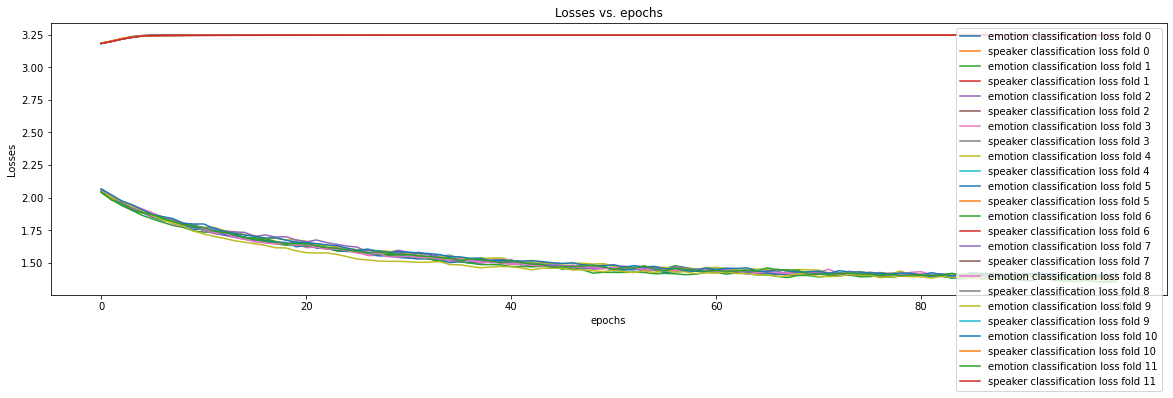

In [14]:
plt.figure(figsize=(20,5))
plt.title('Losses vs. epochs')
plt.xlabel('epochs')
plt.ylabel('Losses')

for i in range(FOLDS):
    plt.plot(range(EPOCHS), fold_emotion_class_losses[i],label='emotion classification loss fold {}'.format(i))
    plt.plot(range(EPOCHS), fold_speaker_class_losses[i],label='speaker classification loss fold {}'.format(i))

plt.legend(loc='best')
plt.show() 

In [15]:
def plot_accuracies_vs_epochs(fold):
    plt.figure(figsize=(20,5))
    plt.title('Accuracies vs. epochs')
    plt.xlabel('epochs')
    plt.ylabel('Losses')
    plt.plot(range(EPOCHS), fold_emotion_training_accuracies[fold],label='emotion_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[fold],label='emotion_validating_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_speaker_training_accuracies[fold],label='speaker_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_speaker_validating_accuracies[fold],label='speaker_validating_accuracies fold {}'.format(fold))
    plt.legend(loc='best')
    plt.show() 
    print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[fold])*100))
    print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[fold])*100))
    print("Maximum speaker training accuracy:{:.2f}%".format(max(fold_speaker_training_accuracies[fold])*100))
    print("Maximum speaker validating accuracy:{:.2f}%".format(max(fold_speaker_validating_accuracies[fold])*100))

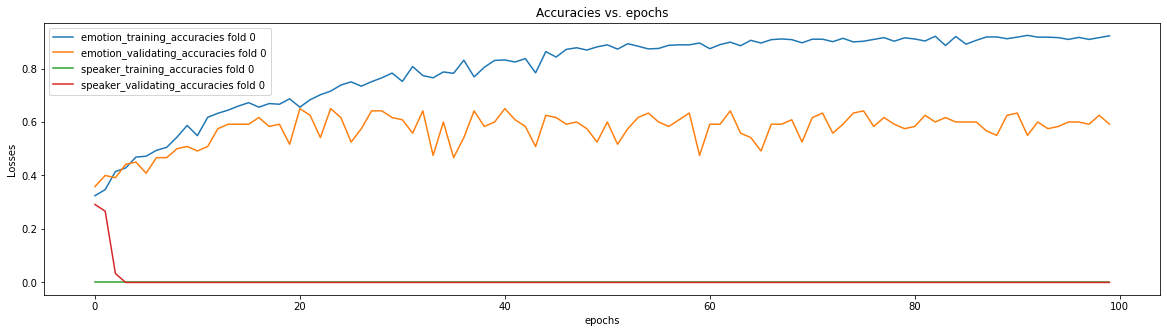

Maximum emotion training accuracy:92.40%
Maximum emotion validating accuracy:65.00%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:29.17%


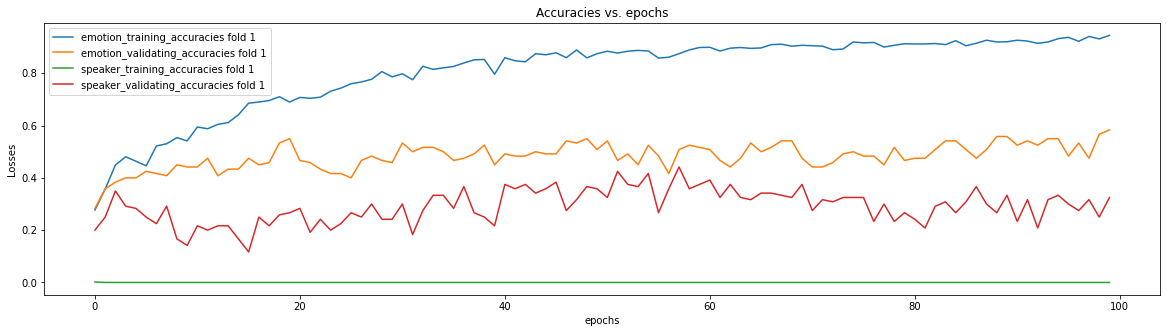

Maximum emotion training accuracy:94.51%
Maximum emotion validating accuracy:58.33%
Maximum speaker training accuracy:0.17%
Maximum speaker validating accuracy:44.17%


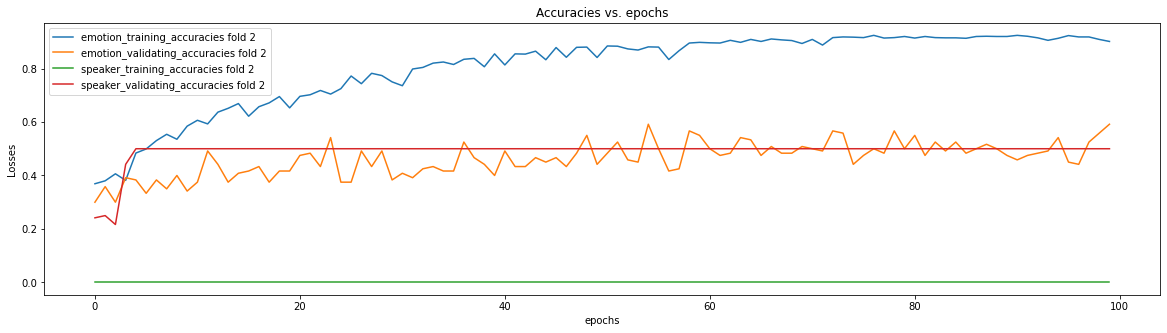

Maximum emotion training accuracy:92.40%
Maximum emotion validating accuracy:59.17%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:50.00%


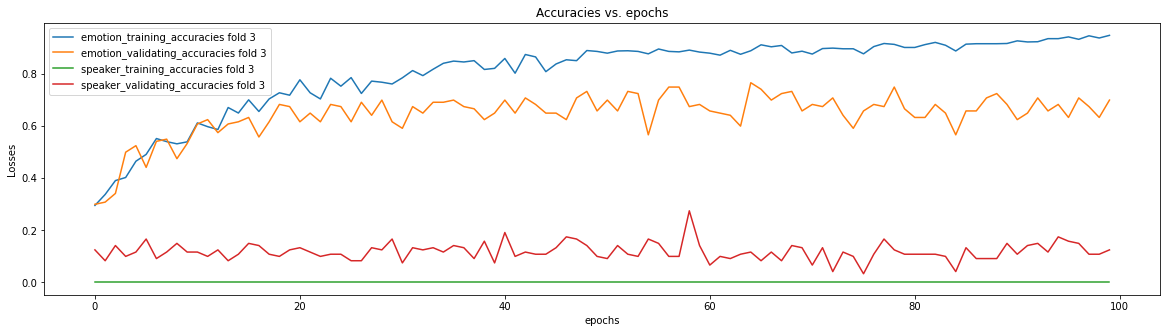

Maximum emotion training accuracy:94.85%
Maximum emotion validating accuracy:76.67%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:27.50%


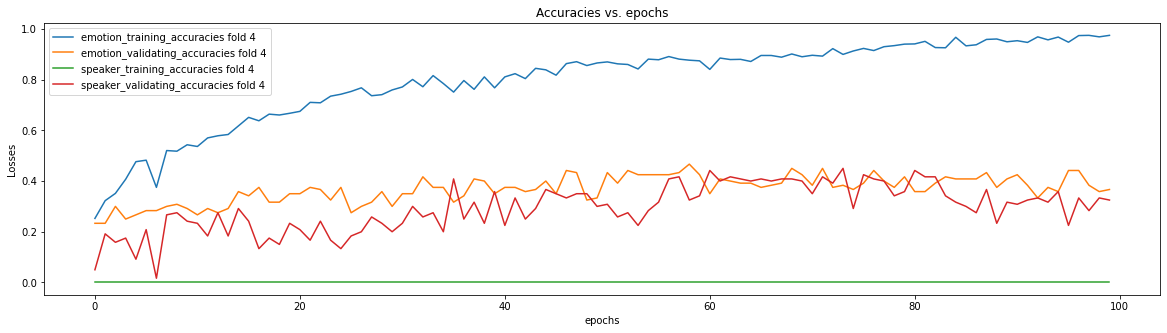

Maximum emotion training accuracy:97.47%
Maximum emotion validating accuracy:46.67%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:45.00%


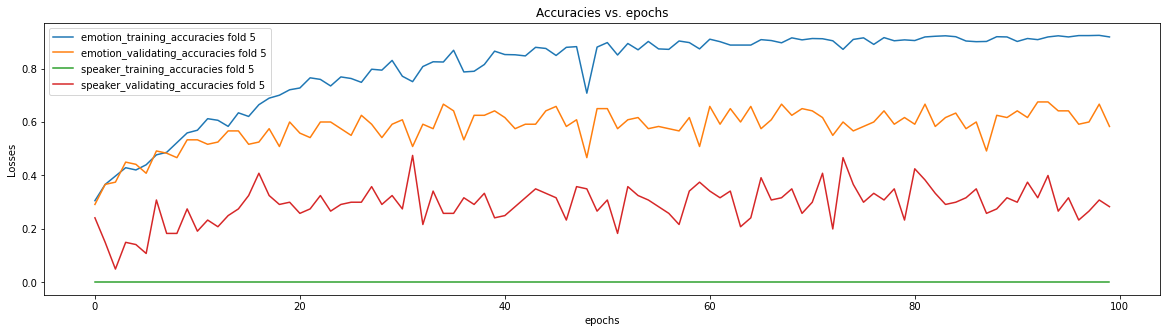

Maximum emotion training accuracy:92.40%
Maximum emotion validating accuracy:67.50%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:47.50%


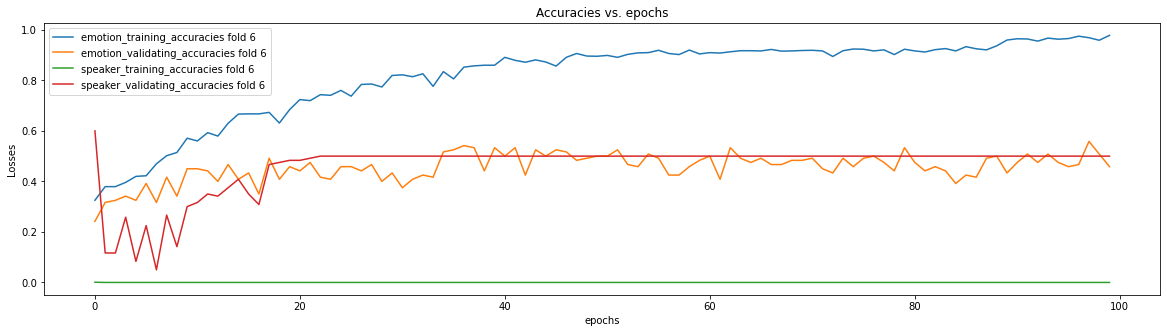

Maximum emotion training accuracy:97.80%
Maximum emotion validating accuracy:55.83%
Maximum speaker training accuracy:0.08%
Maximum speaker validating accuracy:60.00%


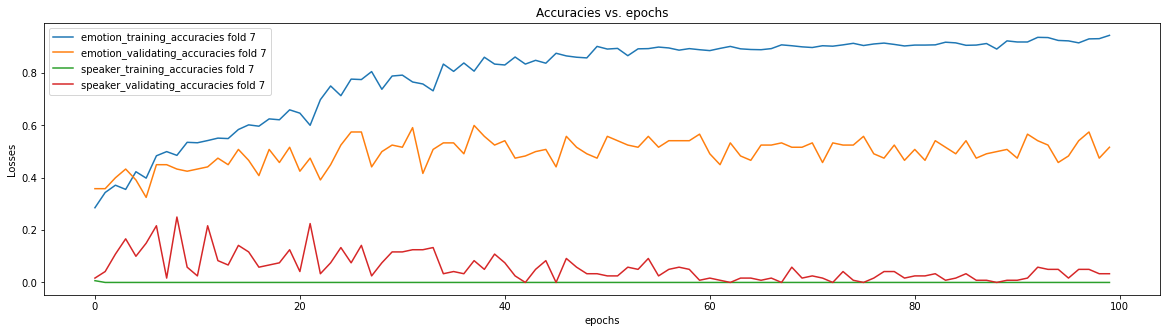

Maximum emotion training accuracy:94.43%
Maximum emotion validating accuracy:60.00%
Maximum speaker training accuracy:0.68%
Maximum speaker validating accuracy:25.00%


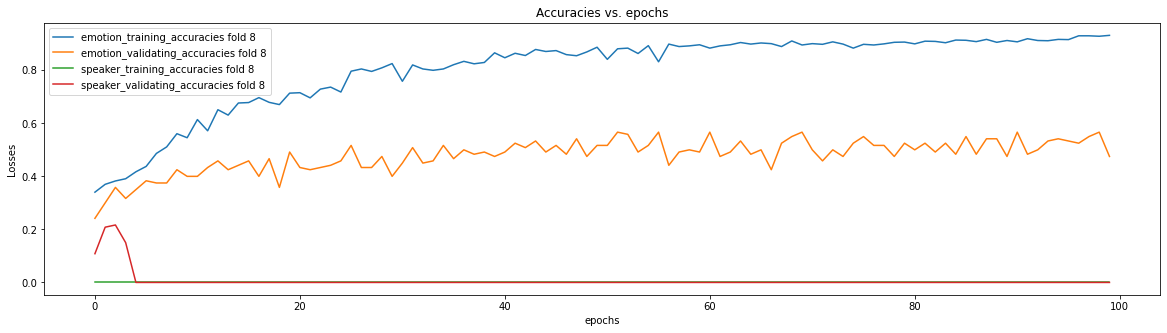

Maximum emotion training accuracy:93.16%
Maximum emotion validating accuracy:56.67%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:21.67%


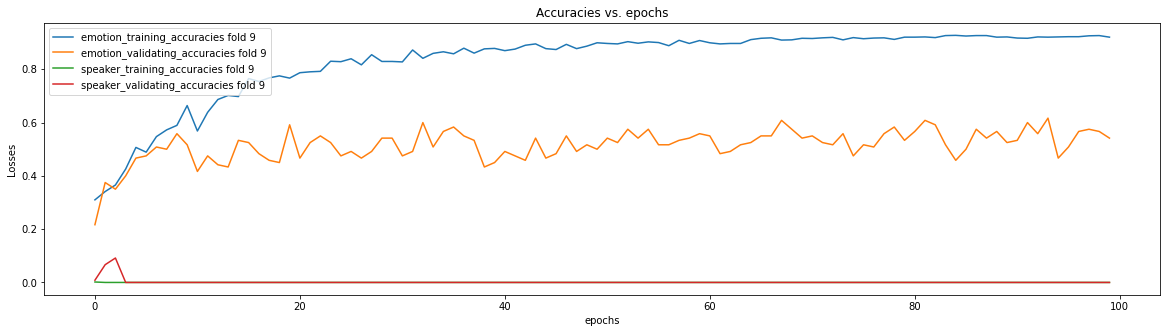

Maximum emotion training accuracy:92.74%
Maximum emotion validating accuracy:61.67%
Maximum speaker training accuracy:0.17%
Maximum speaker validating accuracy:9.17%


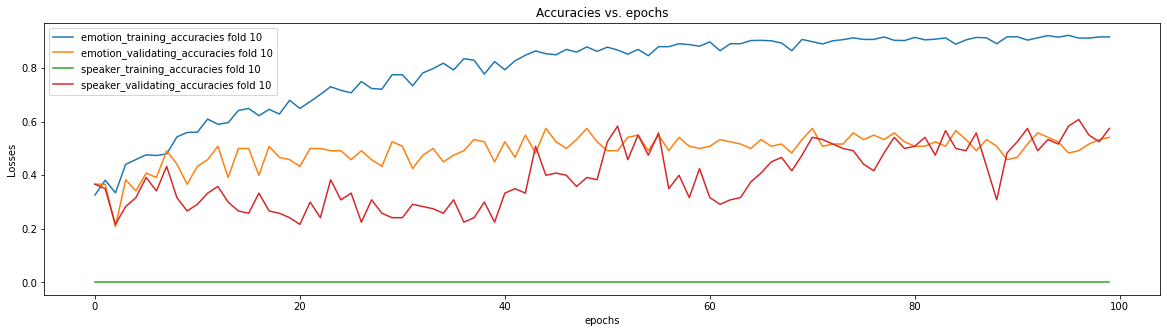

Maximum emotion training accuracy:92.23%
Maximum emotion validating accuracy:57.50%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:60.83%


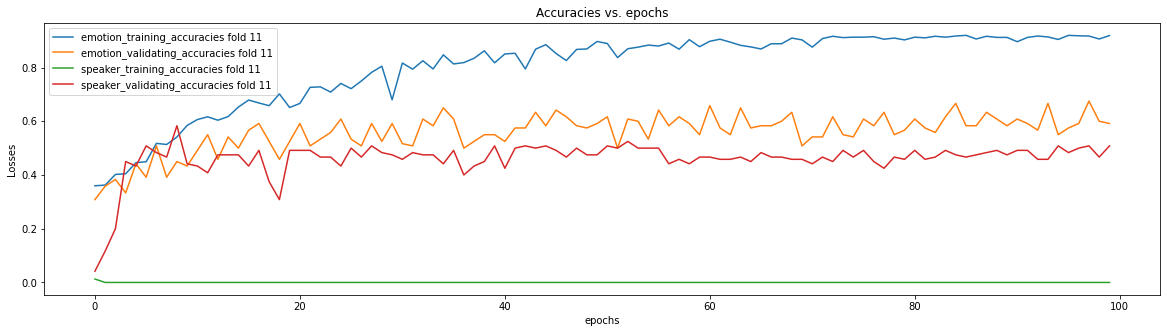

Maximum emotion training accuracy:91.98%
Maximum emotion validating accuracy:67.50%
Maximum speaker training accuracy:1.27%
Maximum speaker validating accuracy:58.33%


In [16]:
for i in range(FOLDS):
    plot_accuracies_vs_epochs(i)

## 5. Loading and evaluating the model

In [17]:
import warnings
warnings.filterwarnings('ignore')
from statistics import mean , stdev


lfold_emotion_training_accuracies, lfold_emotion_validating_accuracies, lfold_emotion_testing_accuracies = [] , [] , []
lfold_speaker_training_accuracies, lfold_speaker_validating_accuracies, lfold_speaker_testing_accuracies = [] , [] , []

for fold in range(12):
    print("\nEvaluation for fold {}".format(fold))
    checkpoint = torch.load(MODEL_PATH + 'fold' + str(fold))
    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    speaker_classifier = SpeakerClassifier().to(DEVICE)

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())
    
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    emotion_classifier.load_state_dict(checkpoint['emotion_classifier_state_dict'])
    speaker_classifier.load_state_dict(checkpoint['speaker_classifier_state_dict'])
    
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    emotion_optimizer.load_state_dict(checkpoint['emotion_optimizer_state_dict'])
    speaker_optimizer.load_state_dict(checkpoint['speaker_optimizer_state_dict'])
    
    ravdess_dataset_train = RavdessDataset2(ROOT,cv_index = fold ,split= 'train')
    ravdess_dataset_test = RavdessDataset2(ROOT,cv_index = fold, split= 'test')
    ravdess_dataset_validate = RavdessDataset2(ROOT,cv_index = fold, split= 'validate')
    
    TRAIN_BATCH_SIZE = len(ravdess_dataset_train)
    VALIDATE_BATCH_SIZE = len(ravdess_dataset_validate)
    TEST_BATCH_SIZE = len(ravdess_dataset_test)
    
    ravdess_train_loader = DataLoader(dataset=ravdess_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    ravdess_validate_loader = DataLoader(dataset=ravdess_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    ravdess_test_loader = DataLoader(dataset=ravdess_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    
    encoder.eval()
    emotion_classifier.eval()

    lemotion_training_correct, lemotion_validating_correct, lemotion_testing_correct = 0 , 0 , 0
    lspeaker_training_correct, lspeaker_validating_correct, lspeaker_testing_correct = 0 , 0 , 0

    with torch.no_grad():
        

        # 1. Training Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_train_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_training_correct += (emotion_preds == emotion).sum() 
            lspeaker_training_correct += (speaker_preds == speaker).sum()
        emotion_training_accuracy = lemotion_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
        speaker_training_accuracy = lspeaker_training_correct.item()/(len(ravdess_train_loader)*TRAIN_BATCH_SIZE)
        print("\nEmotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(lemotion_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))
        print("Speaker Training Correct: {}/{} \nSpeaker Training Accuracy: {:.5f}%".format(lspeaker_training_correct,(len(ravdess_train_loader)*TRAIN_BATCH_SIZE),speaker_training_accuracy*100)) 
        
        # 2. Validating Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_validate_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_validating_correct += (emotion_preds == emotion).sum() 
            lspeaker_validating_correct += (speaker_preds == speaker).sum()
        emotion_validating_accuracy = lemotion_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
        speaker_validating_accuracy = lspeaker_validating_correct.item()/(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE)
        print("\nEmotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(lemotion_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))
        print("Speaker Validating Correct: {}/{} \nSpeaker Validating Accuracy: {:.5f}%".format(lspeaker_validating_correct,(len(ravdess_validate_loader)*VALIDATE_BATCH_SIZE),speaker_validating_accuracy*100)) 
        

        # 3. Testing Classification
        for index, (features, emotion, speaker) in enumerate(ravdess_test_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_testing_correct += (emotion_preds == emotion).sum() 
            lspeaker_testing_correct += (speaker_preds == speaker).sum()
        emotion_testing_accuracy = lemotion_testing_correct.item()/(len(ravdess_test_loader)*TEST_BATCH_SIZE)
        speaker_testing_accuracy = lspeaker_testing_correct.item()/(len(ravdess_test_loader)*TEST_BATCH_SIZE)
        print("\nEmotion Testing Correct: {}/{} \nEmotion Testing Accuracy: {:.5f}%".format(lemotion_testing_correct,(len(ravdess_test_loader)*TEST_BATCH_SIZE),emotion_testing_accuracy*100))
        print("Speaker Testing Correct: {}/{} \nSpeaker Testing Accuracy: {:.5f}%".format(lspeaker_testing_correct,(len(ravdess_test_loader)*TEST_BATCH_SIZE),speaker_testing_accuracy*100)) 

        lfold_emotion_training_accuracies.append(emotion_training_accuracy)
        lfold_emotion_validating_accuracies.append(emotion_validating_accuracy)
        lfold_emotion_testing_accuracies.append(emotion_testing_accuracy)
        lfold_speaker_training_accuracies.append(speaker_training_accuracy)
        lfold_speaker_validating_accuracies.append(speaker_validating_accuracy)
        lfold_speaker_testing_accuracies.append(speaker_testing_accuracy)

print('\nSUMMARY:')
print('\nCV Emotion Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_training_accuracies), stdev(lfold_emotion_training_accuracies)))
print('\nCV Emotion Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_validating_accuracies), stdev(lfold_emotion_validating_accuracies)))
print('\nCV Emotion Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_testing_accuracies), stdev(lfold_emotion_testing_accuracies)))

print('\nCV Speaker Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_training_accuracies), stdev(lfold_speaker_training_accuracies)))
print('\nCV Speaker Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_validating_accuracies), stdev(lfold_speaker_validating_accuracies)))
print('\nCV Speaker Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_testing_accuracies), stdev(lfold_speaker_testing_accuracies)))


Evaluation for fold 0



Emotion Training Correct: 999/1200 
Emotion Training Accuracy: 83.25000%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 78/120 
Emotion Validating Accuracy: 65.00000%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Emotion Testing Correct: 58/120 
Emotion Testing Accuracy: 48.33333%
Speaker Testing Correct: 49/120 
Speaker Testing Accuracy: 40.83333%

Evaluation for fold 1



Emotion Training Correct: 1133/1200 
Emotion Training Accuracy: 94.41667%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 70/120 
Emotion Validating Accuracy: 58.33333%
Speaker Validating Correct: 34/120 
Speaker Validating Accuracy: 28.33333%



Emotion Testing Correct: 60/120 
Emotion Testing Accuracy: 50.00000%
Speaker Testing Correct: 25/120 
Speaker Testing Accuracy: 20.83333%

Evaluation for fold 2



Emotion Training Correct: 1080/1200 
Emotion Training Accuracy: 90.00000%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 71/120 
Emotion Validating Accuracy: 59.16667%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Emotion Testing Correct: 83/120 
Emotion Testing Accuracy: 69.16667%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

Evaluation for fold 3



Emotion Training Correct: 1065/1200 
Emotion Training Accuracy: 88.75000%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 92/120 
Emotion Validating Accuracy: 76.66667%
Speaker Validating Correct: 15/120 
Speaker Validating Accuracy: 12.50000%



Emotion Testing Correct: 51/120 
Emotion Testing Accuracy: 42.50000%
Speaker Testing Correct: 54/120 
Speaker Testing Accuracy: 45.00000%

Evaluation for fold 4



Emotion Training Correct: 1052/1200 
Emotion Training Accuracy: 87.66667%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 56/120 
Emotion Validating Accuracy: 46.66667%
Speaker Validating Correct: 29/120 
Speaker Validating Accuracy: 24.16667%



Emotion Testing Correct: 73/120 
Emotion Testing Accuracy: 60.83333%
Speaker Testing Correct: 15/120 
Speaker Testing Accuracy: 12.50000%

Evaluation for fold 5



Emotion Training Correct: 1101/1200 
Emotion Training Accuracy: 91.75000%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 45/120 
Speaker Validating Accuracy: 37.50000%



Emotion Testing Correct: 55/120 
Emotion Testing Accuracy: 45.83333%
Speaker Testing Correct: 9/120 
Speaker Testing Accuracy: 7.50000%

Evaluation for fold 6



Emotion Training Correct: 1162/1200 
Emotion Training Accuracy: 96.83333%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 67/120 
Emotion Validating Accuracy: 55.83333%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Emotion Testing Correct: 69/120 
Emotion Testing Accuracy: 57.50000%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

Evaluation for fold 7



Emotion Training Correct: 971/1200 
Emotion Training Accuracy: 80.91667%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 72/120 
Emotion Validating Accuracy: 60.00000%
Speaker Validating Correct: 16/120 
Speaker Validating Accuracy: 13.33333%

Emotion Testing Correct: 61/120 
Emotion Testing Accuracy: 50.83333%
Speaker Testing Correct: 54/120 
Speaker Testing Accuracy: 45.00000%

Evaluation for fold 8



Emotion Training Correct: 1112/1200 
Emotion Training Accuracy: 92.66667%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 68/120 
Emotion Validating Accuracy: 56.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Emotion Testing Correct: 74/120 
Emotion Testing Accuracy: 61.66667%
Speaker Testing Correct: 60/120 
Speaker Testing Accuracy: 50.00000%

Evaluation for fold 9



Emotion Training Correct: 1105/1200 
Emotion Training Accuracy: 92.08333%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 74/120 
Emotion Validating Accuracy: 61.66667%
Speaker Validating Correct: 0/120 
Speaker Validating Accuracy: 0.00000%



Emotion Testing Correct: 80/120 
Emotion Testing Accuracy: 66.66667%
Speaker Testing Correct: 64/120 
Speaker Testing Accuracy: 53.33333%

Evaluation for fold 10



Emotion Training Correct: 1078/1200 
Emotion Training Accuracy: 89.83333%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 69/120 
Emotion Validating Accuracy: 57.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Emotion Testing Correct: 74/120 
Emotion Testing Accuracy: 61.66667%
Speaker Testing Correct: 9/120 
Speaker Testing Accuracy: 7.50000%

Evaluation for fold 11



Emotion Training Correct: 1102/1200 
Emotion Training Accuracy: 91.83333%
Speaker Training Correct: 0/1200 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 81/120 
Emotion Validating Accuracy: 67.50000%
Speaker Validating Correct: 60/120 
Speaker Validating Accuracy: 50.00000%



Emotion Testing Correct: 67/120 
Emotion Testing Accuracy: 55.83333%
Speaker Testing Correct: 0/120 
Speaker Testing Accuracy: 0.00000%

SUMMARY:

CV Emotion Training accuracies 
Mean: 0.9 
S.D: 0.04463799396310843

CV Emotion Validating accuracies 
Mean: 0.6104166666666667 
S.D: 0.07513666000540402

CV Emotion Testing accuracies 
Mean: 0.5590277777777778 
S.D: 0.0844215562415735

CV Speaker Training accuracies 
Mean: 0.0 
S.D: 0.0

CV Speaker Validating accuracies 
Mean: 0.26319444444444445 
S.D: 0.20920901820825819

CV Speaker Testing accuracies 
Mean: 0.23541666666666666 
S.D: 0.2156188240222251
